In [5]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
import os
import numpy.ma as ma
from collections import Counter
from dateutil.relativedelta import relativedelta
from scipy.stats import chi2_contingency, kruskal, fisher_exact
from scipy.stats import spearmanr, kendalltau
from statannotations.Annotator import Annotator
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as mtick
from statsmodels.stats.multitest import multipletests

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
hfont = {'fontname':'Arial'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

In [9]:
key_regions = ["hippocampus", "parahippocampal", "entorhinal", "amygdala", "cingulate", "frontal", "occipital", "ventricle"]
def get_selected_cols(cols, key_regions):
    region_dict = {}
    cols_include = []
    for region in key_regions:
        region_dict[region] = [_ for _, col in enumerate(cols) if region in col.lower()]
        cols_include += region_dict[region]
    return cols_include

## Change the path to the pickled file

In [10]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole33_mixture_GMM/pickle_files/sim_tadpole33_subtype3.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [11]:
pkl["ml_subtype"].shape

(850, 1)

In [12]:
pkl["samples_likelihood"].shape

(2000000, 1)

### Check that the MCI and CN/AD files have same column names

In [9]:
# # MCI and CN/AD data
# cn_ad_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_cnad_no_5ventricle.csv"
# df_cnad = pd.read_csv(cn_ad_path)
# mci_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_mci_no_5_ventricle.csv"
# df_mci = pd.read_csv(mci_path)
# df_cnad["EXAMDATE"] = pd.to_datetime(df_cnad["EXAMDATE"])
# df_mci["EXAMDATE"] = pd.to_datetime(df_mci["EXAMDATE"])
# assert all(df_mci.columns == df_cnad.columns)

In [13]:
# MCI and CN/AD data
cn_ad_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_cnad_no_5ventricle_adj.csv"
df_cnad = pd.read_csv(cn_ad_path)
mci_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_mci_no_5ventricle_adj.csv"
df_mci = pd.read_csv(mci_path)
df_cnad["EXAMDATE"] = pd.to_datetime(df_cnad["EXAMDATE"])
df_mci["EXAMDATE"] = pd.to_datetime(df_mci["EXAMDATE"])
assert all(df_mci.columns == df_cnad.columns)

## Subtyping and Staging the subjects

### Get the probability matrices for CN/AD

In [14]:
# Get the mixture model for the CN/AD subjects
k=118
X = df_cnad.iloc[:,:k].values
bm_names = df_cnad.columns[:k].tolist()
y = df_cnad["DX"].map({"Dementia":1, "CN":0})
mm_fit = mixture_model.fit_all_gmm_models
mixture_models = mm_fit(X, y)
L_yes = np.zeros(X.shape)
L_no = np.zeros(X.shape)
for i in range(k):
    L_no[:, i], L_yes[:, i] = mixture_models[i].pdfs_mixture_components(X[:, i], None)

L_no = process_L(L_no)
L_yes = process_L(L_yes)

### Create a SuStaIn object to call the associated methods

In [15]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [24,24,24,23,23]
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 2
p_absorb = 0.3
N_em = 100
SuStaInLabels = df_cnad.columns[:k].tolist()
dataset_name            = 'sim_tadpole33'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes, L_no, n_stages, stage_sizes, min_clust_size, p_absorb, rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, N_iterations_MCMC, N_em, output_folder, dataset_name, use_parallel_startpoints)

### Get the prob mat for the mci subjects

In [16]:
# Get the prob mat for the mci subjects
X_mci = df_mci.iloc[:,:k].values
prob_mat_mci = mixture_model.get_prob_mat(X_mci, mixture_models)
L_no_mci = prob_mat_mci[:,:,0]
L_yes_mci = prob_mat_mci[:,:,1]
L_no_mci = process_L(L_no_mci)
L_yes_mci = process_L(L_yes_mci)

### Subtype and Stage the MCI subjects

In [17]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_newData = sEBMSustainData(L_yes_mci, L_no_mci, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci, ll = sustain.subtype_and_stage_individuals(sustainData_newData, shape_seq, samples_sequence, samples_f, N_samples)


In [18]:
np.mean(ll), np.std(ll)

(-771535.0390465037, 23.042331465770808)

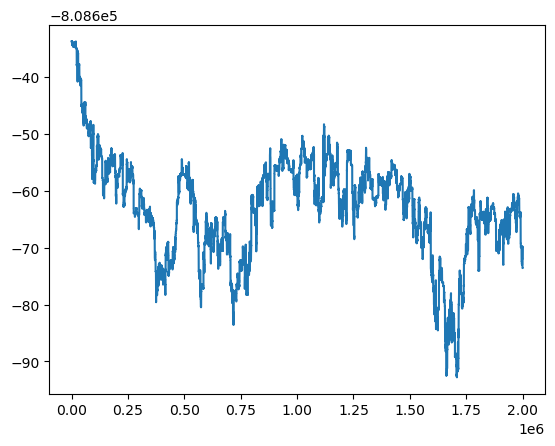

In [19]:
# plt.plot(ll)
plt.plot(pkl["samples_likelihood"])

### Subtype and Stage CN/AD data

In [20]:
# subtype and stage CN/AD data

sustainData_cnad = sEBMSustainData(L_yes, L_no, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]

ml_subtype_cnad, \
prob_ml_subtype_cnad, \
ml_stage_cnad, \
prob_ml_stage_cnad, \
prob_subtype_cnad, \
prob_stage_cnad, \
prob_subtype_stage_cnad, _ = sustain.subtype_and_stage_individuals(sustainData_cnad, shape_seq, samples_sequence,
                                                                   samples_f, N_samples)


In [21]:
n_cnad = ml_subtype_cnad.shape[0]
n_mci = ml_subtype_mci.shape[0]
unique_cnad, counts_cnad = np.unique(ml_subtype_cnad, return_counts=True)
unique_mci, counts_mci = np.unique(ml_subtype_mci, return_counts=True)

fraction_cnad = {}
dict_cnad = dict(zip(unique_cnad, counts_cnad))
for k, v in dict_cnad.items():
    fraction_cnad[k] = v/n_cnad
    
fraction_mci = {}
dict_mci = dict(zip(unique_mci, counts_mci))
for k, v in dict_mci.items():
    fraction_mci[k] = v/n_mci
    
print("CN/AD fractions across subtypes : \n", fraction_cnad)
print("MCI fractions across subtypes : \n", fraction_mci)

CN/AD fractions across subtypes : 
 {0.0: 0.49411764705882355, 1.0: 0.18, 2.0: 0.17647058823529413, 3.0: 0.14941176470588236}
MCI fractions across subtypes : 
 {0.0: 0.4665841584158416, 1.0: 0.1905940594059406, 2.0: 0.17202970297029702, 3.0: 0.1707920792079208}


### Get subjects for a givensubtype

### Prepare final dataframe which has subtype, stage, PTID, DX, and EXAMDATE for all subjects

In [22]:
# DataFrame for CN/AD subjects
array_subtype_stage_cnad = np.hstack([ml_subtype_cnad, ml_stage_cnad, y.values.reshape(-1,1)])
cnad_solved = pd.DataFrame(data=array_subtype_stage_cnad, columns=["subtype", "stage", "DX"])
cnad_solved[["PTID", "EXAMDATE", "VISCODE"]] = df_cnad[["PTID", "EXAMDATE", "VISCODE"]]

In [23]:
# DataFrame for MCI subjects
array_subtype_stage_mci = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_solved = pd.DataFrame(data=array_subtype_stage_mci, columns=["subtype", "stage"])
mci_solved["DX"] = 2.0
mci_solved[["PTID", "EXAMDATE", "VISCODE"]] = df_mci[["PTID", "EXAMDATE", "VISCODE"]]
final_df = pd.concat([cnad_solved, mci_solved], axis=0)

In [24]:
final_df["DX"] = final_df["DX"].map({0.0:"Controls", 1.0:"AD", 2.0:"MCI"})

# Prepare final_df (Add RID)

In [25]:
final_df["RID"] = final_df["PTID"].apply(lambda x: int(x.split("_")[-1]))

# Process data for filtering operations / StatsModel

In [26]:
def process_df(df, fld, keep="first"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_fld.drop_duplicates("sid", keep=keep, inplace=True)
    return df_fld

def regress_score(df, field, covariates, examdate="EXAMDATE", n_subtypes=4):
    subtypes = list(range(n_subtypes))
    df_fld = df.dropna(subset=[field])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    one_hot_cols = pd.get_dummies(df_fld["subtype"])
    one_hot_cols = one_hot_cols[subtypes]
    new_cols = ["st{}".format(_) for _ in subtypes]
    one_hot_cols.columns = new_cols
    df_one_hot = pd.concat([df_fld[covariates+[field]], one_hot_cols], axis=1)
    return df_one_hot

def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

def regress_OLS_logodds(df, fld, cov):
    model = sm.OLS(np.log(df[[fld]]/(1 - df[[fld]])), sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

### Directory path

In [23]:
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole33_mixture_GMM/figures_4/neurobattery_run33_adj"

# Prepare Longitudinal Data  with subtypes and stages

In [24]:
# Functions for reading longitudinal data and subtyping/staging
def read_long(df_cnad, df_mci, k):
    long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
    df_long = pd.read_csv(long_path)
    df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])
    assert all(df_long.columns[:k] == df_cnad.columns[:k])
    cnad_ptid = df_cnad["PTID"].tolist()
    mci_ptid = df_mci["PTID"].tolist()
    df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
    df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]
    return df_long, df_long_cnad, df_long_mci

def subtype_stage(L_yes, L_no, pkl, n_stages, last_N=1000000, N_samples=1000):
    sustainData_mci_long = sEBMSustainData(L_yes, L_no, n_stages)
    samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
    samples_f = pkl["samples_f"][:,-last_N:]
    shape_seq = pkl["shape_seq"]
    temp_mean_f = np.mean(samples_f, axis=1)
    ix = np.argsort(temp_mean_f)[::-1]

    ml_subtype, \
    prob_ml_subtype, \
    ml_stage, \
    prob_ml_stage, \
    prob_subtype, \
    prob_stage, \
    prob_subtype_stage,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)
    return ml_subtype, prob_ml_subtype, ml_stage, prob_ml_stage, prob_subtype, prob_stage, prob_subtype_stage

# Read the long df (MCI and CNAD)
k = 118
df_long, df_long_cnad, df_long_mci = read_long(df_cnad, df_mci, k)

# Get the prob_mat for MCI
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

# Subtype and Stage the MCI subjects and subset them for the relevant columns
ml_subtype_mci, prob_ml_subtype_mci, ml_stage_mci, \
prob_ml_stage_mci, prob_subtype_mci, prob_stage_mci, prob_subtype_stage_mci = subtype_stage(L_yes_mci_long, L_no_mci_long, pkl, n_stages)
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci
df_long_mci["RID"] = df_long_mci["sid"].apply(lambda x: int(x.split("_")[-1]))
df_long_mci["PTGENDER"] = df_long_mci["PTGENDER"].map({"Female":0, "Male":1})
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid", "RID", "AGE", "PTGENDER", "PTEDUCAT", "APOE4"]
df_long_mci_subset = df_long_mci[mci_subset]

In [25]:
prob_mat_cnad_long = mixture_model.get_prob_mat(df_long_cnad.iloc[:,:k].values, mixture_models)
L_no_cnad_long = prob_mat_cnad_long[:,:,0]
L_yes_cnad_long = prob_mat_cnad_long[:,:,1]
L_yes_cnad_long = process_L(L_yes_cnad_long)
L_no_cnad_long = process_L(L_no_cnad_long)
# Subtype and Stage the CN/AD subjects and subset them for the relevant columns
ml_subtype_cnad, prob_ml_subtype_cnad, ml_stage_cnad, \
prob_ml_stage_cnad, prob_subtype_cnad, prob_stage_cnad, prob_subtype_stage_cnad = subtype_stage(L_yes_cnad_long, L_no_cnad_long, pkl, n_stages)
df_long_cnad["subtype"] = ml_subtype_cnad
df_long_cnad["stage"] = ml_stage_cnad
df_long_cnad["RID"] = df_long_cnad["sid"].apply(lambda x: int(x.split("_")[-1]))
df_long_cnad["PTGENDER"] = df_long_cnad["PTGENDER"].map({"Female":0, "Male":1})
cnad_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid", "RID", "AGE", "PTGENDER", "PTEDUCAT", "APOE4"]
df_long_cnad_subset = df_long_cnad[cnad_subset]

In [26]:
df_long_all = pd.concat([df_long_cnad, df_long_mci], axis=0)

## Read the ADNIMERGE file 

In [27]:
# Read the ADNIMERGE file     
adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
df_adnimerge =pd.read_csv(adnimerge_path)
df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])

In [28]:
df_adnimerge["ABETA"] = df_adnimerge["ABETA"].replace([">1700","<200"],[1700,200])
df_adnimerge["ABETA"] = df_adnimerge["ABETA"].astype(float)
df_adnimerge["TAU"] = df_adnimerge["TAU"].replace(["<80",">1300"],[80,1300])
df_adnimerge["TAU"] = df_adnimerge["TAU"].astype(float)
df_adnimerge["PTAU"] = df_adnimerge["PTAU"].replace(["<8", ">120"],[8,120])
df_adnimerge["PTAU"] = df_adnimerge["PTAU"].astype(float)

In [29]:
df_long_adnimerge = pd.merge(df_long_mci, df_adnimerge, on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_"])
df_long_adnimerge.sort_values(by=["PTID", "EXAMDATE"], inplace=True)
df_long_adnimerge["stage"] = df_long_adnimerge["stage"].astype(int)

In [30]:
df_long_all_adnimerge = pd.merge(df_long_all, df_adnimerge, on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_"])
df_long_all_adnimerge.sort_values(by=["PTID", "EXAMDATE"], inplace=True)
df_long_all_adnimerge["stage"] = df_long_all_adnimerge["stage"].astype(int)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.787e-01 U_stat=7.902e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.497e-01 U_stat=1.356e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.352e-01 U_stat=9.822e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.604e-03 U_stat=1.074e+04
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.419e-01 U_stat=4.415e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-s

3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.597e-07 U_stat=1.761e+04
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.701e-01 U_stat=4.114e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.150e-02 U_stat=9.330e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.622e-01 U_stat=1.618e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.461e-01 U_stat=1.055e+04
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.791e-06 U_stat=1.716e+04
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.102e-01 U_stat=4.280e+03


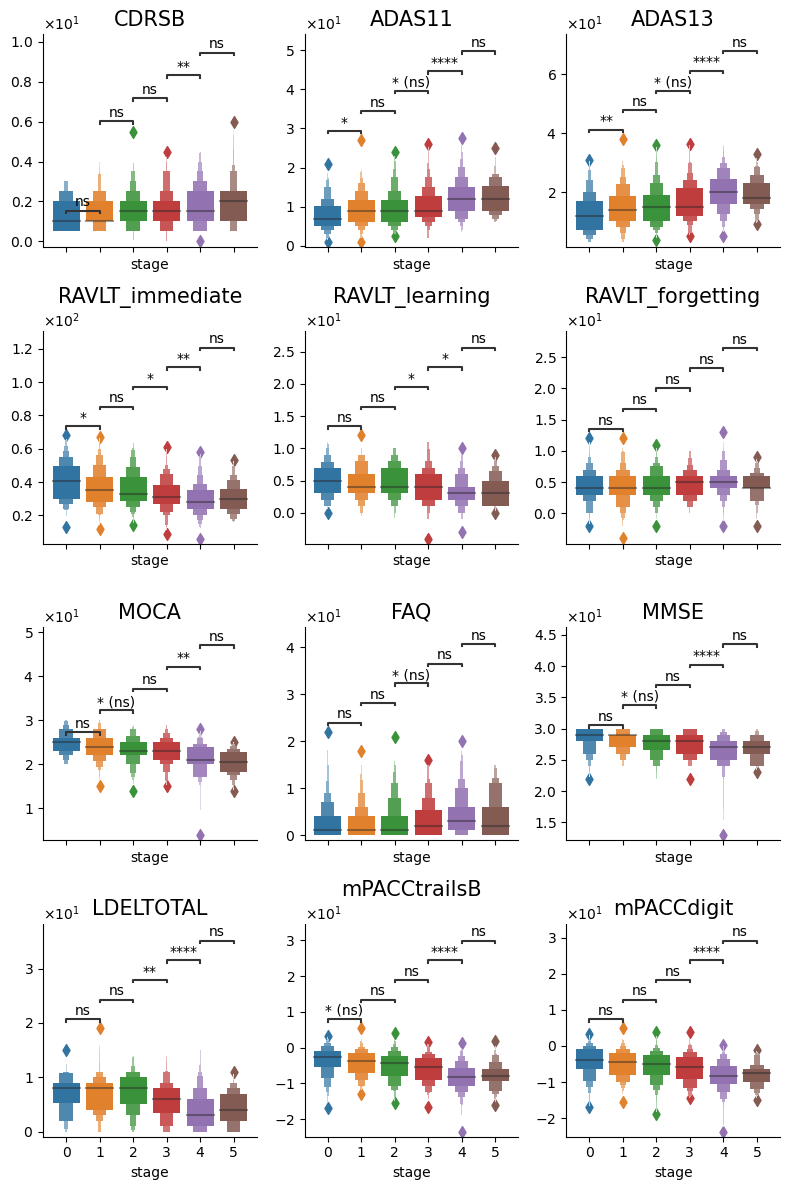

In [31]:
flds = ["CDRSB", "ADAS11", "ADAS13"] + ["RAVLT_immediate","RAVLT_learning",
        "RAVLT_forgetting"] + ["MOCA", "FAQ","MMSE"] + ["LDELTOTAL", "mPACCtrailsB", "mPACCdigit"]

pairs = [(0,1),(1,2),(2,3),(3,4),(4,5)]
fig, ax = plt.subplots(4,3, sharex=True, sharey=False, figsize=(8,12))
test_name = "composite_neuropsych_score_stat_annotator"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
    annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Benjamini-Hochberg")
    annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [32]:
dir_path

'/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2'

# Individual fields (MOCA)

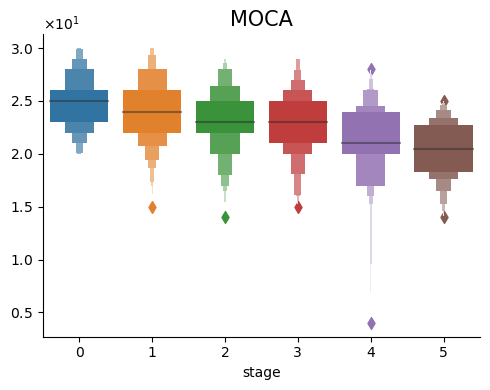

In [34]:
fld = "MOCA"
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(5,4))
test_name = "MOCA_test"
df_mh_fld = process_df(df_long_adnimerge, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax)
ax.set_ylabel("")
ax.set_title(fld, fontsize=15)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
dir_path = '/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2'
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [35]:
fld = "MOCA"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[cov1]))
results = model.fit()

## Median Regression (example)

In [36]:
model = smf.quantreg("MOCA ~ AGE + PTGENDER + APOE4 + PTEDUCAT + stage + st1 + st2 + st3", df_xx)
fld = "TAU"
df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
model = smf.quantreg("TAU ~ AGE + PTGENDER + APOE4 + PTEDUCAT + stage + st1 + st2 + st3", df_xx)
res = model.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    TAU   Pseudo R-squared:              0.09117
Model:                       QuantReg   Bandwidth:                       60.46
Method:                 Least Squares   Sparsity:                        244.4
Date:                Wed, 15 May 2024   No. Observations:                  551
Time:                        13:51:35   Df Residuals:                      542
                                        Df Model:                            8
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.8734     67.333     -0.280      0.779    -151.140     113.393
AGE            3.9754      0.845      4.702      0.000       2.315       5.636
PTGENDER     -18.3390     11.991     -1.529      0.127     -41.894       5.217
APOE4         60.2811      7.869      7.661      0.0

## EcogPT/SP scores

### Study Partner (SP)

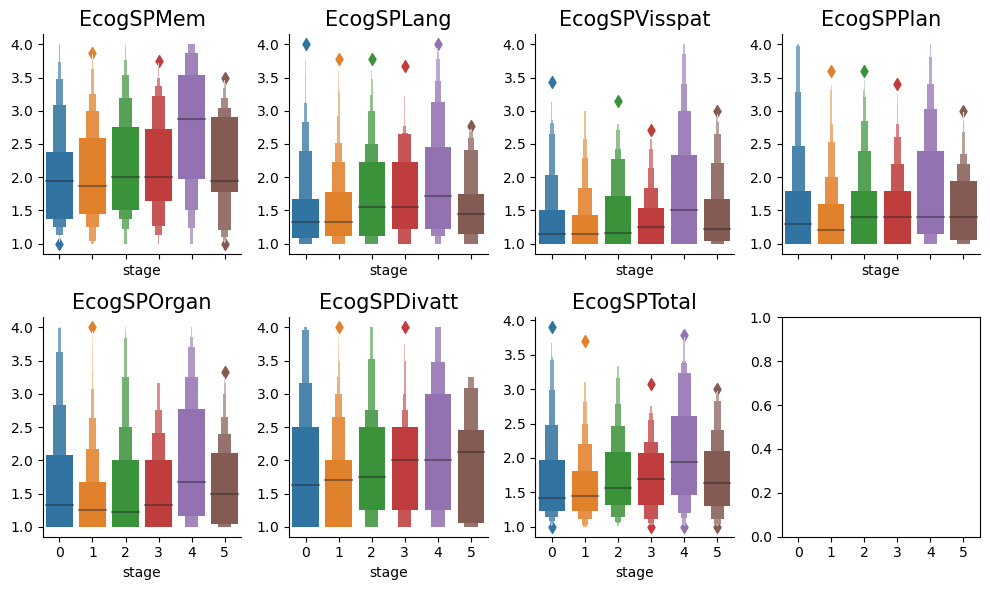

In [40]:
flds = ["EcogSPMem", "EcogSPLang", "EcogSPVisspat", "EcogSPPlan",
        "EcogSPOrgan", "EcogSPDivatt", "EcogSPTotal"]

pairs = [(0,1),(1,2),(2,3),(3,4),(4,5)]
fig, ax = plt.subplots(2,4, sharex=True, sharey=False, figsize=(10,6))
test_name = "EcogSP"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//4
    c = _%4
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
#     annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
#     annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
#     annotator.configure(test='Mann-Whitney', text_format='star', 
#                         loc='inside',comparisons_correction="Benjamini-Hochberg")
#     annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [41]:
test_name = "EcogSP_summary_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

### Study Participant (Pt)

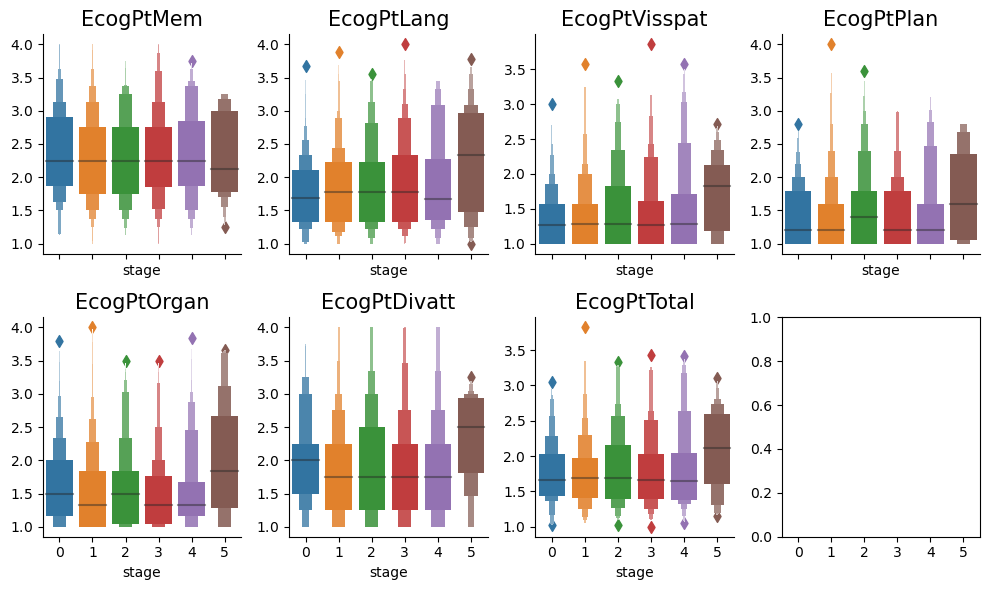

In [42]:
flds = ["EcogPtMem", "EcogPtLang", "EcogPtVisspat", "EcogPtPlan",
        "EcogPtOrgan", "EcogPtDivatt", "EcogPtTotal"]

pairs = [(0,1),(1,2),(2,3),(3,4),(4,5)]
fig, ax = plt.subplots(2,4, sharex=True, sharey=False, figsize=(10,6))
test_name = "EcogPT"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//4
    c = _%4
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
#     annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
#     annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
#     annotator.configure(test='Mann-Whitney', text_format='star', 
#                         loc='inside',comparisons_correction="Benjamini-Hochberg")
#     annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [43]:
test_name = "EcogPT_summary_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

## CSF markers

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.504e-02 U_stat=6.352e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.590e-01 U_stat=7.983e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.425e-01 U_stat=4.932e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.889e-03 U_stat=6.377e+03
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.102e-01 U_stat=1.364e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-s

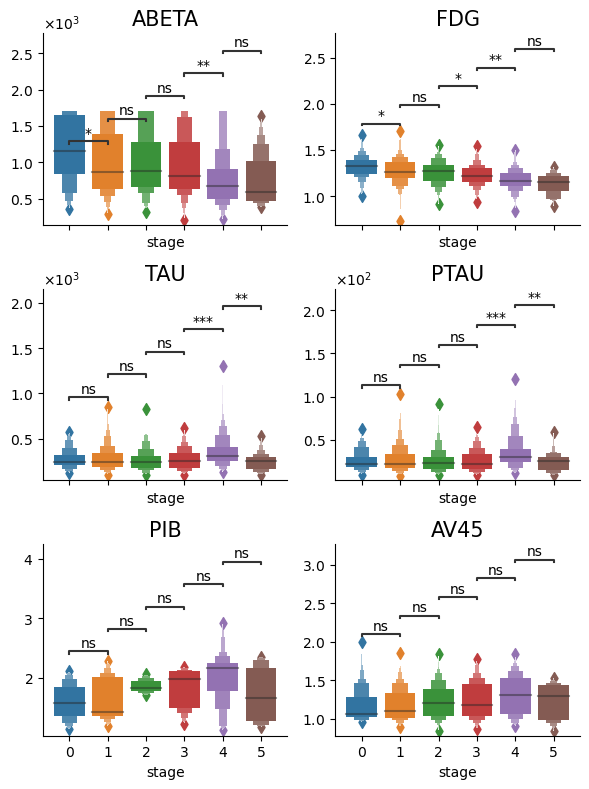

In [44]:
flds = ["ABETA","FDG","TAU","PTAU","PIB","AV45"]
fig, ax = plt.subplots(3,2, sharex=True, sharey=False, figsize=(6,8))
test_name = "CSF_markers_annotation"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//2
    c = _%2
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
    annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Benjamini-Hochberg")
    annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

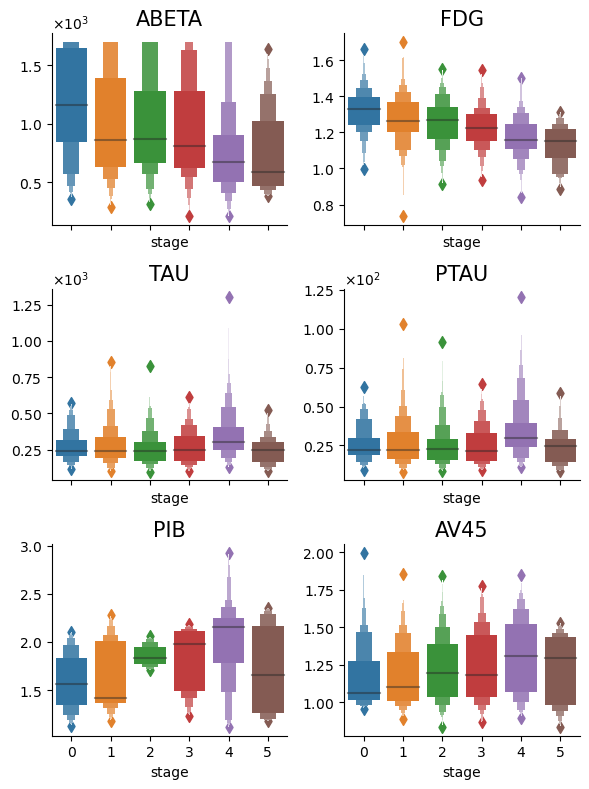

In [46]:
flds = ["ABETA","FDG","TAU","PTAU","PIB","AV45"]
fig, ax = plt.subplots(3,2, sharex=True, sharey=False, figsize=(6,8))
test_name = "CSF_markers"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//2
    c = _%2
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

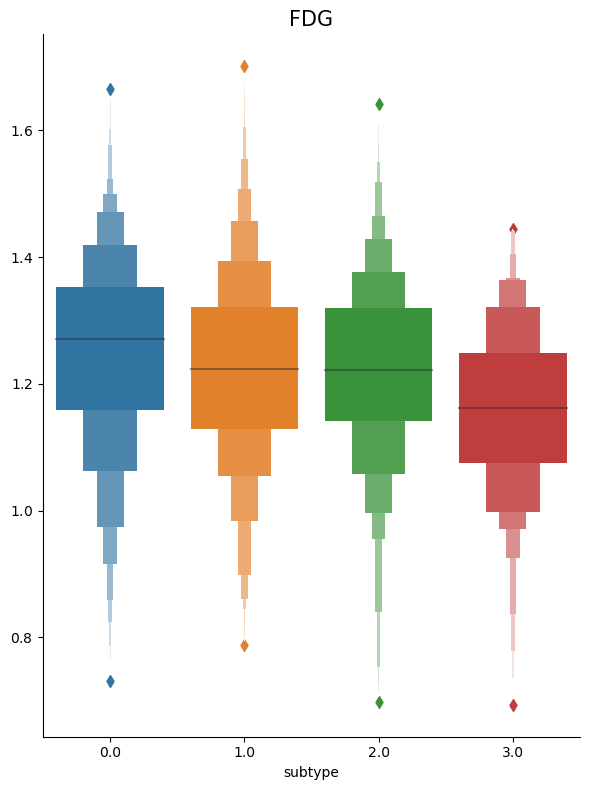

In [53]:
flds = ["FDG"]
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(6,8))
test_name = "CSF_markers"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_all_adnimerge, fld)
    r = _//2
    c = _%2
    sns.boxenplot(data=df_mh_fld, y=fld, ax=ax, x="subtype")
    ax.set_ylabel("")
    ax.set_title(fld, fontsize=15)
    ax.spines[['right', 'top']].set_visible(False)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [54]:
# p-value for abeta across subtypes BEFORE adjusting for age, gender, education APOE4
kruskal(*[group[fld].values for name, group in df_mh_fld.groupby("subtype")])

KruskalResult(statistic=47.56752607493224, pvalue=2.632064069562859e-10)

In [55]:
# Adjusting ABeta levels for age, gender, educat, apoe4
fld = "FDG"
df_xx = regress_score(df_long_all_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[["AGE", "PTGENDER", "PTEDUCAT", "APOE4"]]))
results = model.fit()


In [56]:
df_xx

,AGE,PTGENDER,PTEDUCAT,APOE4,stage,FDG,st0,st1,st2,st3
7,89.6,0,16,0.0,4,1.46097,0,1,0,0
2463,57.8,1,20,0.0,1,1.41429,0,0,1,0
2472,62.9,0,20,1.0,1,1.31212,0,1,0,0
2479,72.2,0,20,1.0,1,1.37612,1,0,0,0
2482,63.4,0,20,0.0,0,1.50477,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2441,76.5,0,16,0.0,3,1.33321,1,0,0,0
5398,69.3,0,12,1.0,3,1.49934,1,0,0,0
5402,81.4,1,18,0.0,0,1.25884,1,0,0,0
5406,82.7,0,20,0.0,4,1.36562,0,1,0,0


In [57]:
df_xx["subtype"] = pd.from_dummies(df_xx[["st0","st1","st2","st3"]])

KruskalResult(statistic=3.0828135366293736, pvalue=0.3790323610245887)

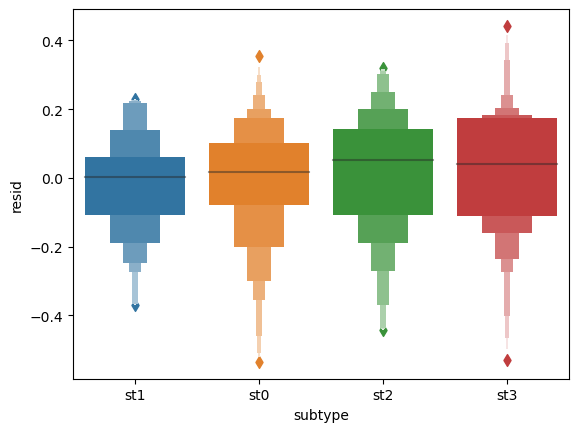

In [58]:
df_xx["resid"] = results.resid
sns.boxenplot(data=df_xx, y="resid", x="subtype")
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

In [59]:
test_name = "CSF_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_long_adnimerge, fld)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_obj = spearmanr(df_mh_fld["stage"], df_mh_fld[fld])
    spearman_corr = spearmanr_obj.correlation
    spearman_pval = spearmanr_obj.pvalue
    
    neurobat_dict[fld] = [chi2_pval, spearman_corr, spearman_pval, n_samples]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", 
                                     columns = ["chi-2-pval", "spearmanr", "spearmanp", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape FDG (618, 244)


In [60]:
test_name = "CSF_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

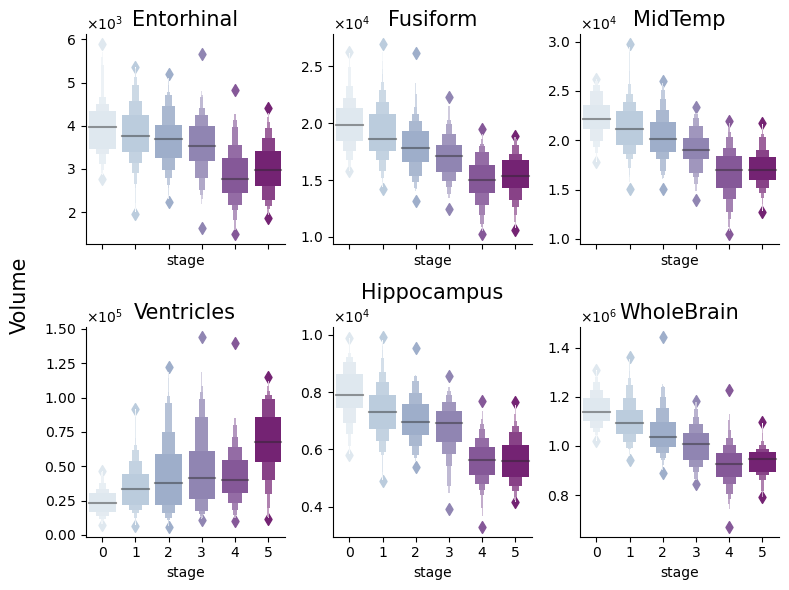

In [61]:
test_name = "Vol_test"
flds =  ["Entorhinal", "Fusiform", "MidTemp", "Ventricles", "Hippocampus", "WholeBrain"]
fig, ax = plt.subplots(2,3, sharex=True, sharey=False, figsize=(8,6))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette="BuPu")
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
#     ax[r,c].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.supylabel("Volume", fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [62]:
test_name = "vol_test_bar"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

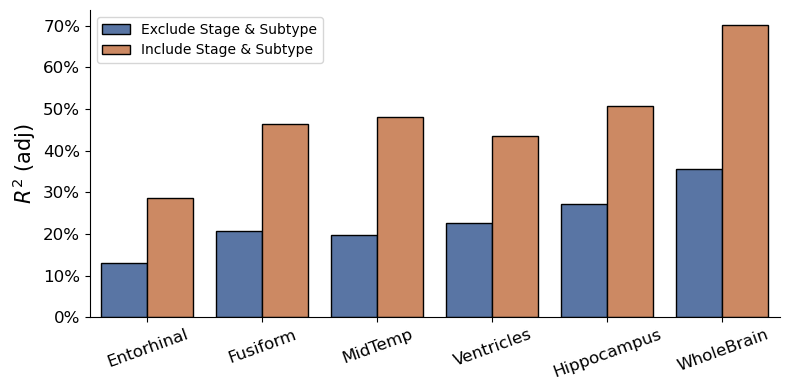

In [63]:
stats_df_all["r-sq-adj"] *= 100
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot(data=stats_df_all, x="fld", y="r-sq-adj", hue="n-cov", 
            hue_order = ["excl-sustain", "incl-sustain"], ax=ax,
           palette="deep", edgecolor='k', 
            order=["Entorhinal", "Fusiform", "MidTemp", "Ventricles", "Hippocampus", "WholeBrain"])
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12,rotation=20)
ax.set_ylabel(r'$R^{2}$ (adj)', fontsize=15)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
leg = ax.get_legend()
leg.set_title("")
new_labels = ['Exclude Stage & Subtype', 'Include Stage & Subtype']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

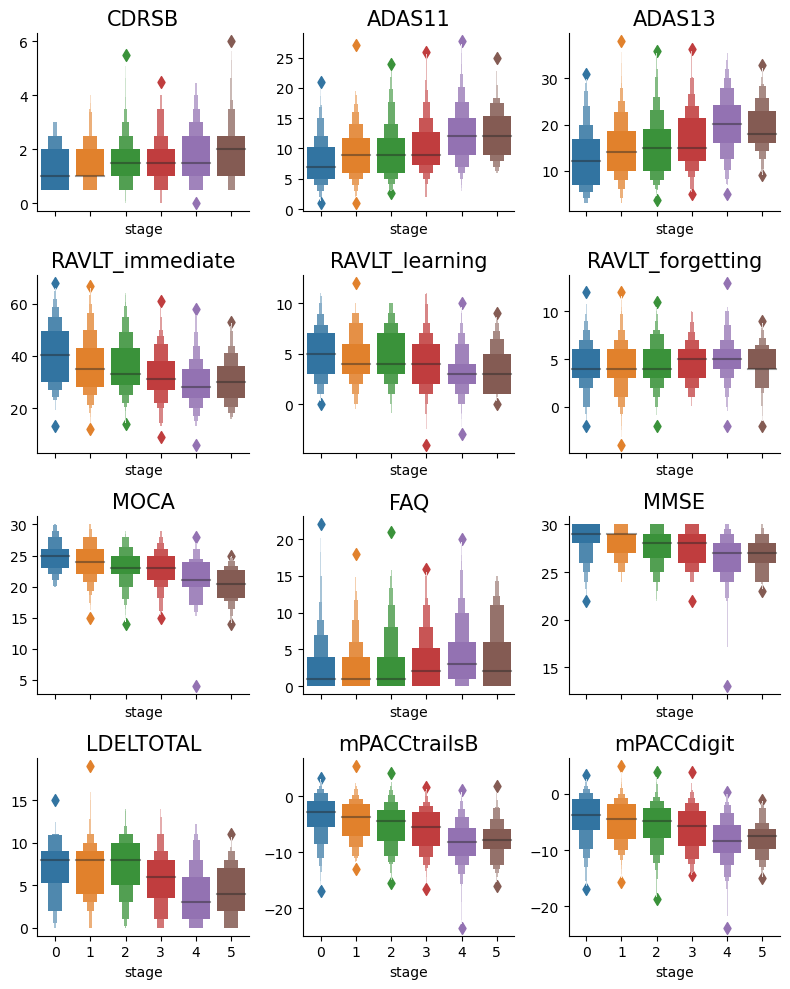

In [64]:
test_name = "adnimerge_cog"
flds = ["CDRSB", "ADAS11", "ADAS13"] + ["RAVLT_immediate","RAVLT_learning",
        "RAVLT_forgetting"] + ["MOCA", "FAQ","MMSE"] + ["LDELTOTAL", "mPACCtrailsB", "mPACCdigit"]
fig, ax = plt.subplots(4,3, sharex=True, sharey=False, figsize=(8,10))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
#     if fld in ["RAVLT_forgetting"]:
#         df_mh_fld = df_mh_fld[fld]
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_ylabel("")
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [65]:
test_name = "adnimerge_cog_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

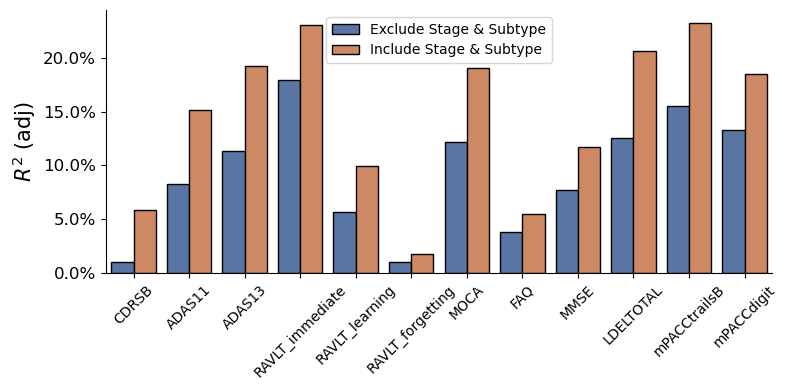

In [66]:
stats_df_all["r-sq-adj"] *= 100
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot(data=stats_df_all, x="fld", y="r-sq-adj", hue="n-cov", 
            hue_order = ["excl-sustain", "incl-sustain"], ax=ax,
           palette="deep", edgecolor='k')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=10,rotation=45)
ax.set_ylabel(r'$R^{2}$ (adj)', fontsize=15)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
leg = ax.get_legend()
leg.set_title("")
new_labels = ['Exclude Stage & Subtype', 'Include Stage & Subtype']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}_bar.png".format(test_name)), dpi=300)

# Relations between subtypes and Ethnicity, Race, Marry etc

In [67]:
# PTGENDER, #PTMARRY
fld = "PTMARRY"
df_mh_fld = process_df(df_long_all_adnimerge, fld,"first")
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_contingency(chi2_table)

(36.514692448694205,
 0.0002676823490588967,
 12,
 array([[7.13275030e+01, 6.27482509e+02, 3.04264174e+01, 2.99276236e+00,
         9.47708082e+01],
        [3.48443908e+01, 3.06533172e+02, 1.48636912e+01, 1.46200241e+00,
         4.62967431e+01],
        [2.29420989e+01, 2.01826297e+02, 9.78648975e+00, 9.62605549e-01,
         3.04825090e+01],
        [1.38860072e+01, 1.22158022e+02, 5.92340169e+00, 5.82629674e-01,
         1.84499397e+01]]))

In [68]:
chi2_table

PTMARRY,Divorced,Married,Never married,Unknown,Widowed
subtype,,,,,
0.0,92,593,25,3,114
1.0,32,305,21,1,45
2.0,15,222,9,1,19
3.0,4,138,6,1,12


In [69]:
chi2_table.sum().sum()

1658

In [70]:
df_mh_fld

,3rd-Ventricle,4th-Ventricle,Brain-Stem,CC_Anterior,CC_Central,CC_Mid_Anterior,CC_Mid_Posterior,CC_Posterior,CSF,CortexVol,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2016,1594,21966,718,330,334,341,747,1744,428237.8199,...,355.2,34.73,NaN,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:29.0
2,2274,1717,20363,743,352,361,309,844,1537,454812.9567,...,107.3,10.57,NaN,NaN,NaN,1.065020,12.75410,12,12,2019-02-14 23:58:30.0
5,2942,3382,24986,885,356,387,338,976,1260,416770.2777,...,188.6,15.82,NaN,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:31.0
6,5319,3291,20851,641,222,209,223,732,3518,442137.1497,...,212.4,18.56,NaN,NaN,NaN,0.481862,5.77049,6,6,2019-02-14 23:58:31.0
7,3394,1751,19979,738,319,320,295,811,1423,361653.4100,...,265.9,22.82,NaN,NaN,NaN,3.986310,47.73770,48,48,2019-02-14 23:58:32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,1789,2143,21078,623,388,324,268,915,1281,362288.1733,...,277,23.97,1.33321,NaN,0.933541,0.000000,0.00000,0,0,2019-02-14 23:58:40.0
5398,1048,1313,16963,624,350,313,346,848,1313,371425.3641,...,312.6,26.47,1.49934,NaN,1.126160,0.000000,0.00000,0,0,2019-02-14 23:58:40.0
5402,1171,1675,19683,766,396,437,387,982,1587,422901.8755,...,339.4,32.22,1.25884,NaN,1.361980,0.000000,0.00000,0,0,2019-02-14 23:58:41.0
5406,3234,3131,20749,476,273,197,202,755,2035,385137.6643,...,295.5,27.57,1.36562,NaN,1.221260,0.000000,0.00000,0,0,2019-02-14 23:58:43.0


# Demographics (Age, gender, education APOE4)

In [71]:
df_mci_demo = pd.merge(mci_solved, df_mci[["PTID", "APOE4", "PTGENDER", "PTEDUCAT", "AGE"]], left_on="PTID", right_on="PTID", how="inner")
df_cnad_demo = pd.merge(cnad_solved, df_cnad[["PTID", "APOE4", "PTGENDER", "PTEDUCAT", "AGE"]], left_on="PTID", right_on="PTID", how="inner")
df_demo = pd.concat([df_cnad_demo, df_mci_demo], axis=0)         

In [72]:
df_demo

,subtype,stage,DX,PTID,EXAMDATE,VISCODE,APOE4,PTGENDER,PTEDUCAT,AGE
0,3.0,2.0,0.0,002_S_0295,2006-05-09,bl,1.0,Male,18,84.8
1,0.0,1.0,0.0,002_S_0413,2007-06-01,m12,0.0,Female,16,76.3
2,3.0,1.0,0.0,002_S_0559,2006-06-20,bl,1.0,Male,16,79.3
3,3.0,2.0,1.0,002_S_0619,2006-12-13,m06,2.0,Male,12,77.5
4,1.0,4.0,0.0,002_S_0685,2010-07-15,m48,0.0,Female,16,89.6
...,...,...,...,...,...,...,...,...,...,...
803,2.0,3.0,2.0,941_S_4100,2015-08-28,m48,0.0,Female,12,78.5
804,0.0,0.0,2.0,941_S_4187,2011-08-25,bl,0.0,Male,16,62.0
805,0.0,3.0,2.0,941_S_4377,2012-02-14,bl,1.0,Female,12,69.3
806,0.0,0.0,2.0,941_S_4420,2012-04-03,bl,0.0,Male,18,81.4


In [73]:
df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1) 

APOE4,0.0,1.0,2.0
subtype,,,
0.0,423,318,82
1.0,226,138,39
2.0,151,93,22
3.0,77,60,24


# APOE4 allele frequency

In [74]:
np.dot(df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1), [0,1,2])/(2*df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1).sum(axis=1))

subtype
0.0    0.292831
1.0    0.267990
2.0    0.257519
3.0    0.335404
dtype: float64

In [75]:
chi2_table = df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1).fillna(0)
chi2_contingency(chi2_table)

(9.014375636214629,
 0.17277120801849452,
 6,
 array([[436.6430732 , 303.21052632,  83.14640048],
        [213.81185723, 148.47368421,  40.71445856],
        [141.12643678,  98.        ,  26.87356322],
        [ 85.41863279,  59.31578947,  16.26557774]]))

## Education and Age

In [76]:
[(name, group["AGE"].std()) for name, group in df_demo.groupby("subtype")]

[(0.0, 7.487124628399423),
 (1.0, 6.287189705390494),
 (2.0, 6.831692780333247),
 (3.0, 6.374589379054371)]

In [78]:
kruskal(*[group["PTEDUCAT"].values for name, group in df_demo.groupby("subtype")])

KruskalResult(statistic=10.875362153880397, pvalue=0.012419288927591548)

<AxesSubplot: xlabel='subtype', ylabel='PTEDUCAT'>

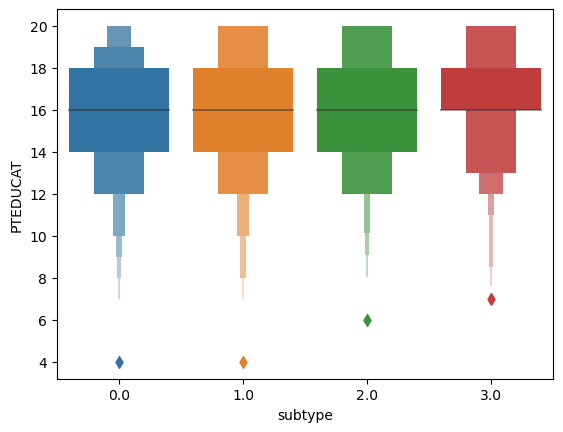

In [79]:
sns.boxenplot(data=df_demo, x="subtype",y="PTEDUCAT")

In [80]:
df_st0 = df_demo[df_demo["subtype"]==0]
df_st1 = df_demo[df_demo["subtype"]==1]
df_st2 = df_demo[df_demo["subtype"]==2]
df_st3 = df_demo[df_demo["subtype"]==3]

In [81]:
demo_x = "PTEDUCAT"
kruskal(df_st0[demo_x], df_st1[demo_x], df_st2[demo_x],df_st3[demo_x])

KruskalResult(statistic=10.875362153880397, pvalue=0.012419288927591548)

# Prepare data for StatsModel

In [82]:
def regress_score(df, field, covariates, examdate="EXAMDATE", n_subtypes=4):
    subtypes = list(range(n_subtypes))
    df_fld = df.dropna(subset=[field])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    one_hot_cols = pd.get_dummies(df_fld["subtype"])
    one_hot_cols = one_hot_cols[subtypes]
    new_cols = ["st{}".format(_) for _ in subtypes]
    one_hot_cols.columns = new_cols
    df_one_hot = pd.concat([df_fld[covariates+[field]], one_hot_cols], axis=1)
    return df_one_hot

def process_df(df, fld, examdate="EXAMDATE"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    return df_fld

def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

# Process data for filtering operations

## OLS regression function

In [83]:
def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

## Logistic regression function

In [84]:
def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

# NeuroBAT

In [85]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NEUROBAT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

# Trail Tests

### Regression Models

In [87]:
flds = ["TRAASCOR","TRAAERRCOM","TRAAERROM","TRABSCOR","TRABERRCOM","TRABERROM"]
test_name = "trail_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [88]:
flds = ["TRAASCOR","TRAAERRCOM","TRAAERROM","TRABSCOR","TRABERRCOM","TRABERROM"]
test_name = "trail_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", 
                                     columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape TRAASCOR (808, 96)
Shape TRAAERRCOM (808, 96)
Shape TRAAERROM (808, 96)
Shape TRABSCOR (806, 96)
Shape TRABERRCOM (804, 96)
Shape TRABERROM (804, 96)


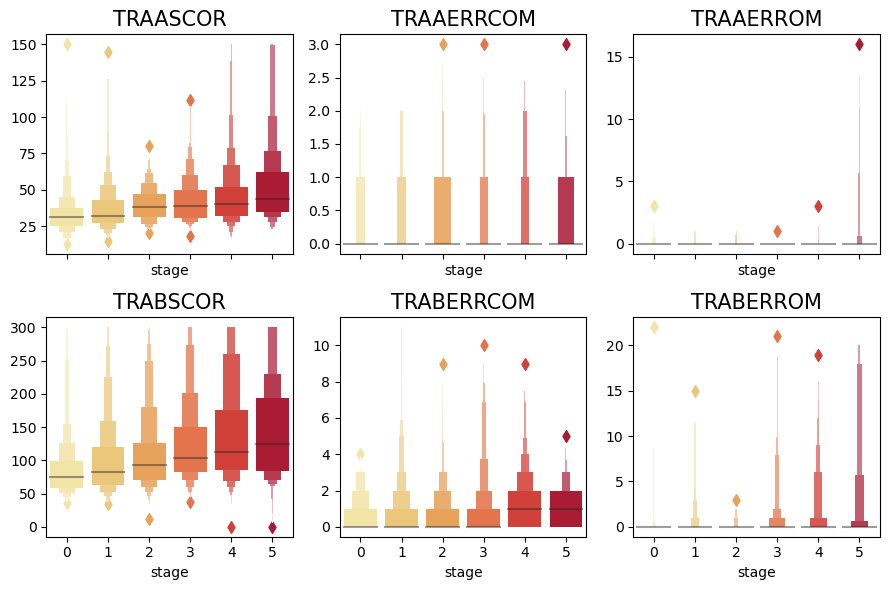

In [89]:
nrows=2
ncols=3
fig, ax = plt.subplots(nrows,ncols, sharex=True, sharey=False, figsize=(9,6))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//ncols
    c = _%ncols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette="YlOrRd")
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### RAVLT

In [90]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape AVTOT1 (808, 96)
Shape AVTOT2 (808, 96)
Shape AVTOT3 (808, 96)
Shape AVTOT4 (808, 96)
Shape AVTOT5 (808, 96)
Shape AVTOT6 (808, 96)
Shape AVTOTB (808, 96)
Shape AVERR1 (808, 96)
Shape AVERR2 (808, 96)
Shape AVERR3 (808, 96)
Shape AVERR4 (808, 96)
Shape AVERR5 (808, 96)
Shape AVERR6 (808, 96)
Shape AVERRB (808, 96)


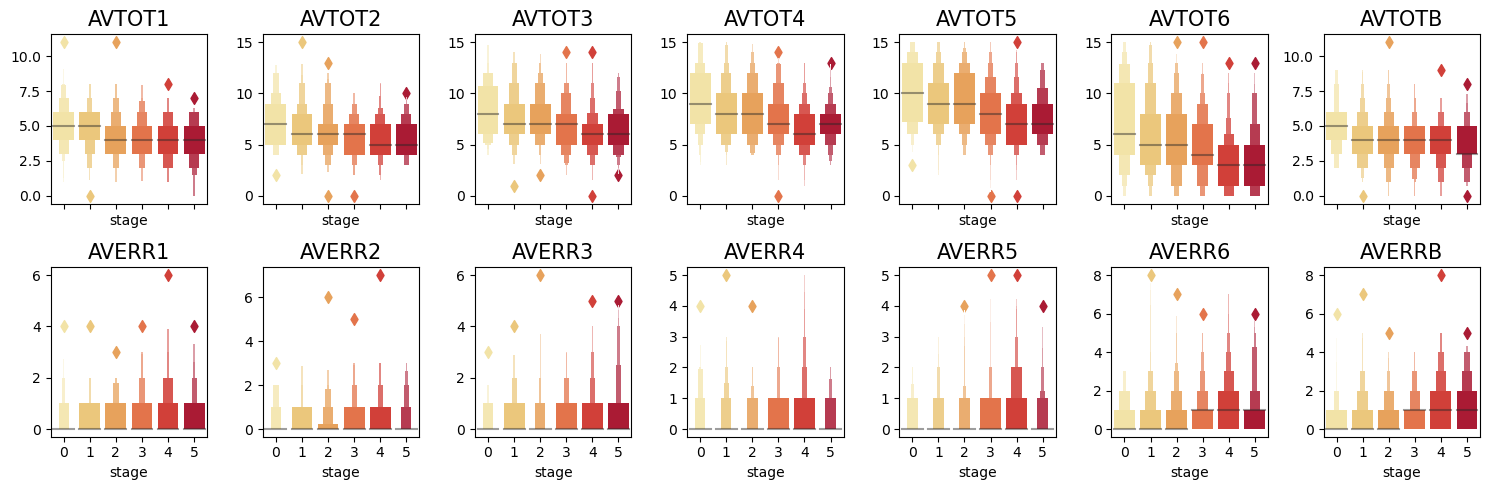

In [91]:
rows = 2; cols=7;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(15,5))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette="YlOrRd")
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### Regression

In [92]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [93]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

### RAVLT delayed

In [94]:
flds = ["AVDEL30MIN", "AVDELERR1", "AVDELTOT", "AVDELERR2"]
test_name = "RAVLT_delayed"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape AVDEL30MIN (808, 96)
Shape AVDELERR1 (808, 96)
Shape AVDELTOT (808, 96)
Shape AVDELERR2 (808, 96)


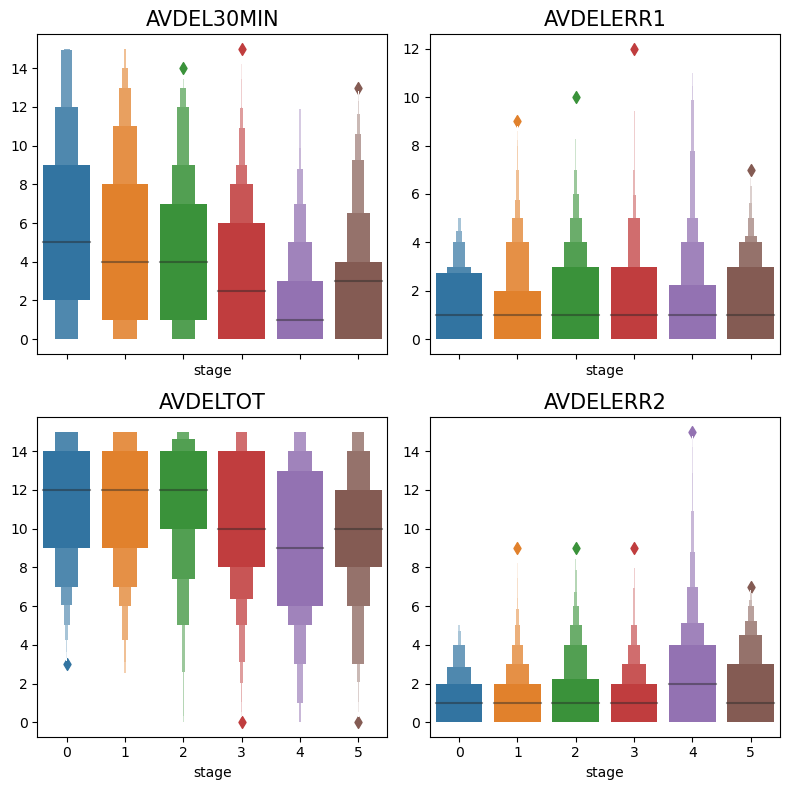

In [95]:
rows = 2; cols=2;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(8,8))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### Regression

In [96]:
flds = ["AVDEL30MIN", "AVDELERR1", "AVDELTOT", "AVDELERR2"]
test_name = "RAVLT_delayed"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# CLOCK tests

In [97]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NEUROBAT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [98]:
flds = ["CLOCKCIRC","CLOCKSYM","CLOCKNUM","CLOCKHAND","CLOCKTIME",
        "COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME","LDELCUE"]
test_name = "clock_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.086007
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.505167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.124916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130925
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587981
  

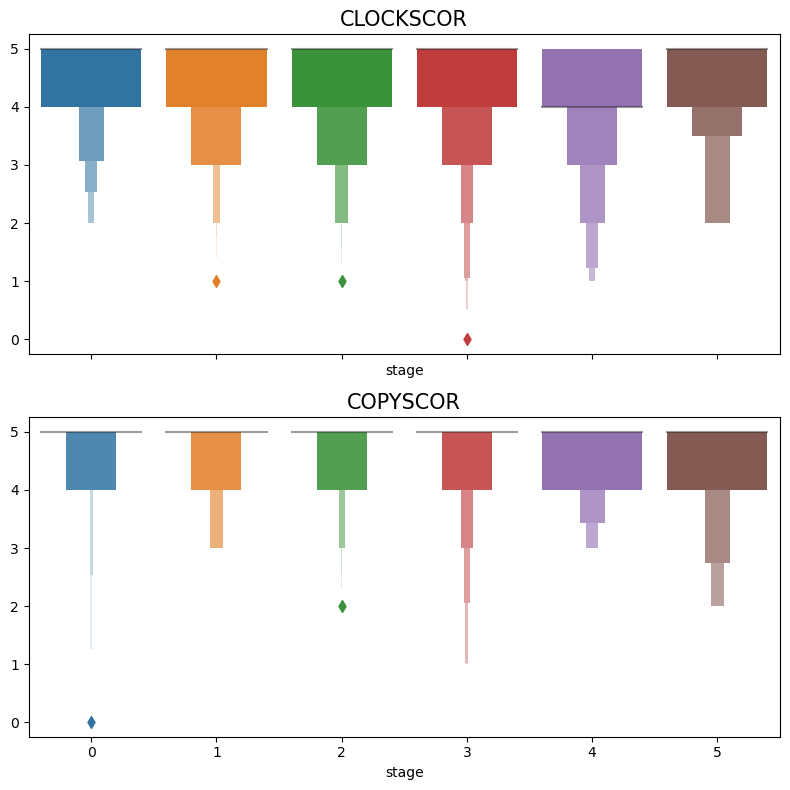

In [99]:
flds = ["CLOCKSCOR", "COPYSCOR"]
test_name = "clock_test"
rows = 2; cols=1;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(8,8))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_])
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# Line plots to show odds of failing a clock test as a fn of stage

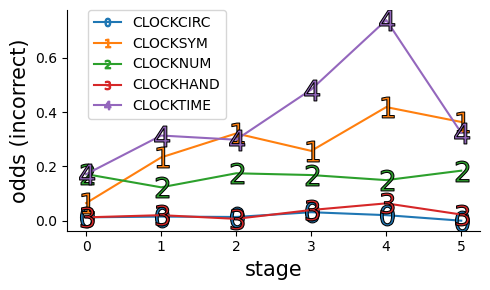

In [100]:
flds = ["CLOCKCIRC","CLOCKSYM","CLOCKNUM","CLOCKHAND","CLOCKTIME"]
# flds = ["COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME"]
binary = flds
test_name = "clock_ratio_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(1,1,figsize=(5,3))
markers = ['${}$'.format(_) for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=15, mec="k")

plt.legend(bbox_to_anchor=(0.05, 1.00), loc='upper left', borderaxespad=0, ncol=1)
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('odds (incorrect)', fontsize=15)
ax.set_xlabel('stage', fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


# Neurobat others

### Logical Memory

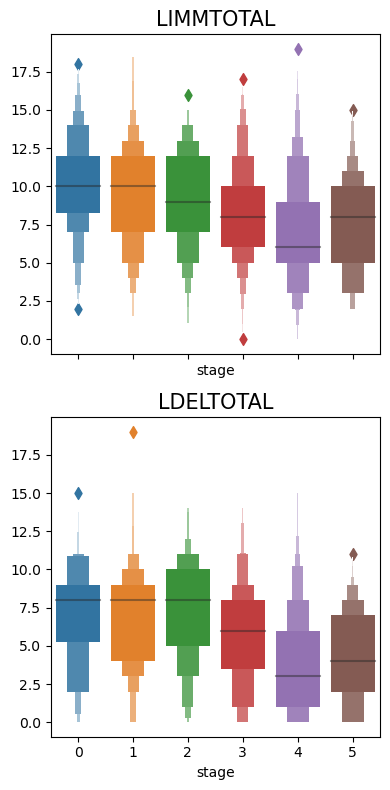

In [101]:
flds = ["LIMMTOTAL", "LDELTOTAL"]
rows = 2; cols=1;
test_name = "logical_memory"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(4,8))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_])
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# LDELCUE

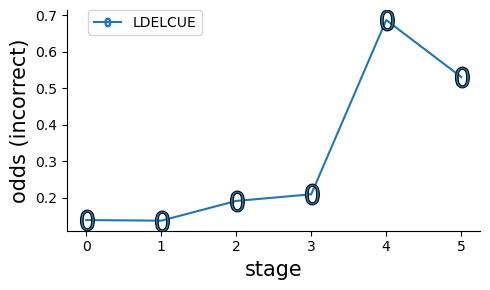

In [102]:
flds = ["LDELCUE"]
# flds = ["COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME"]
binary = flds
test_name = "LDELCUE_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[1]/chi2_table[0]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(1,1,figsize=(5,3))
markers = ['${}$'.format(_) for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=15, mec="k")

plt.legend(bbox_to_anchor=(0.05, 1.00), loc='upper left', borderaxespad=0, ncol=1)
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('odds (incorrect)', fontsize=15)
ax.set_xlabel('stage', fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


In [103]:
flds = ["LDELCUE"]
test_name = "ldelcue_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.479168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495423
         Iterations 6


# DigitSpan test

In [ ]:
flds = ["DSPANFOR", "DSPANFLTH", "DSPANBAC", "DSPANBLTH", "DIGITSCOR"]
rows = 1; cols=5;
test_name = "digit_span"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(10,3))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_])
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
# Category Fluency Test

In [ ]:
flds = ["CATANIMSC", "CATANPERS", "CATANINTR", "CATVEGESC", "CATVGPERS", "CATVGINTR"]
rows = 2; cols=3;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(8,6))
test_name = "cat_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
flds = ["BNTSPONT", "BNTSTIM", "BNTCSTIM", "BNTPHON", "BNTCPHON", "BNTTOTAL"]
rows = 2; cols=3;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(8,6))
test_name = "bnt_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# American National Adult Reading Test

In [ ]:
flds = ["ANARTERR"]
rows = 1; cols=1;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(3,3))
test_name = "anart_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax)
    ax.set_ylabel("")
    ax.set_title(fld, fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# Regression stats for all neurobattery tests (clock, BNT, CATegory etc)

In [ ]:
flds = ["CLOCKSCOR", "COPYSCOR"] + ["LIMMTOTAL", "DSPANFOR", "DSPANFLTH", 
        "DSPANBAC", "DSPANBLTH", "DIGITSCOR", "CATANIMSC", "CATANPERS", "CATANINTR",
        "CATVEGESC", "CATVGPERS", "CATVGINTR"] + ["LDELTOTAL", "BNTSPONT", "BNTSTIM",
        "BNTCSTIM", "BNTPHON", "BNTCPHON", "BNTTOTAL", "ANARTERR"]
test_name = "neurobat_ols_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [ ]:
df_xx = regress_score(df_mh, "ANARTERR", ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
stats_df1 = regress_OLS(df_xx, "ANARTERR", cov1)

In [ ]:
stats_df1

# MMSE

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MMSE_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["PTID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
flds = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
       "WORD1","WORD2","WORD3","MMTRIALS","MMD","MML","MMR","MMO","MMW",
        "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
        "MMONFLR","MMREAD","MMWRITE","MMDRAW","MMSCORE"]
# binary = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
#        "WORD1","WORD2","WORD3","MMD","MML","MMR","MMO","MMW",
#         "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
#         "MMONFLR","MMREAD","MMWRITE","MMDRAW"]
binary = ["WORD1DL", "WORD2DL", "WORD3DL", "MMDATE", "MMFLOOR", "MMDAY", "MMDRAW", "MMAREA", "MMW"]
test_name = "mmse_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(8,6))
markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=15, mec="k")

lgnd = plt.legend(bbox_to_anchor=(0.02, 0.95), loc='upper left', borderaxespad=0, ncol=3)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(12)
    
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds (incorrect)", fontsize=15)
ax.set_xlabel("stage", fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


In [ ]:
neuro_sc = "MMSCORE"
df_xx = regress_score(df_mh, neuro_sc, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[neuro_sc]], 
               sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
results = model.fit()
print(results.summary())

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(4, 4))
sns.boxenplot(data=df_mh_fld, x="stage", y="MMSCORE")
ax.spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "MMSCORE_boxen.png"), dpi=300)


In [ ]:
fld = "WORLDSCORE"
df_mh_fld = process_df(df_mh, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld)

In [ ]:
df_mh["WORLDSCORE"]

## Logistic regression - MMSE

In [ ]:
flds = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
       "WORD1","WORD2","MMD","MML","MMR","MMO","MMW",
        "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
        "MMONFLR","MMREAD","MMWRITE","MMDRAW"]
test_name = "mmse_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# EMBIC

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "EMBICqCP_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print("Shape", df_mh_fld.shape)
    kruskal_stats = kruskal(*[group[fld].values for name, group in df_mh_fld.groupby("stage")])
    kruskal_pval = kruskal_stats.pvalue
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [kruskal_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["kruskal-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


### Regression

In [ ]:
df_xx

In [ ]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test_logodds"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS_logodds(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS_logodds(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [ ]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [ ]:
fmt = '%.2f'
yticks = mtick.FormatStrFormatter(fmt)
fig, ax = plt.subplots(6,5, figsize=(8,10), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 5
    c = i % 5
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
    ax[r,c].yaxis.set_major_formatter(yticks)
    ax[r,c].set_title(fld, fontsize=12)

for _ in range(1,5):
    ax[5,_].set_axis_off()
    
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# ADAS - ADNI GO, 2, 3

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNIGO23_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
flds = ["Q3TASK1", "Q3TASK2", "Q3TASK3", "Q3TASK4", "TOTSCORE", "TOTAL13"]
binary = []
test_name = "adas_go23_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


# Logistic regression for the cube test

In [ ]:
fld = "Q3TASK4"
test_name = "adas_go23_test"
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
df_xx[fld] = df_xx[fld].map({1:1,2:0,3:0})
stats_df1 = regress_Logit(df_xx, fld, cov1)
stats_df1

In [ ]:
df_xx

In [ ]:
fld = "Q3TASK4"
test_name = "adas_go23_test"

ratio_df = pd.DataFrame()
df_mh_fld = process_df(df_mh, fld)
print("Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]
ratio = chi2_table[2]/chi2_table[1]
# ratio_df[fld] = ratio
spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
plt.plot(ratio)


In [ ]:
chi2_table, spearmanr_corr

In [ ]:
flds = ["Q1SCORE", "Q2SCORE", "Q3SCORE", "Q4SCORE", "Q5SCORE",
        "Q6SCORE", "Q7SCORE", "Q8SCORE", "Q9SCORE", "Q10SCORE",
       "Q11SCORE", "TOTSCORE", "Q12SCORE", "Q13SCORE", "TOTAL13"]
fig, ax = plt.subplots(5,3, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 3
    c = i % 3
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT", "AGE", 
                                          "stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [ ]:
stats_df_all

# ADAS - ADNI 1

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNI1_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
df_mh_fld = process_df(df_mh, "COCONSTR")

In [ ]:
def harmonize_coconstr(x):
    l = x.split(":")
    int_l =[int(_) for _ in l]
    int_l.sort()
    res_list = []
    res_list = [1*(_ in int_l) for _ in range(1,6)]
    return res_list

In [ ]:
s = df_mh_fld["COCONSTR"].apply(lambda x: harmonize_coconstr(x))
df_coconstr = pd.DataFrame(np.vstack(s))
df_coconstr.columns = ["no-shape", "circ", "rectangles", "rhombus", "cube"]
df_coconstr2 = pd.concat([df_mh_fld, df_coconstr], axis=1)

In [ ]:
fld = "rectangles"
test_name = "adas_1_test"
ratio_df = pd.DataFrame()
print("Shape", df_coconstr2.shape)
chi2_table = df_coconstr2.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]
ratio = chi2_table[0]/chi2_table[1]
# ratio_df[fld] = ratio
# spearmanr_corr = spearmanr(df_coconstr["stage"], df_coconstr[fld]).correlation
plt.plot(ratio)


In [ ]:
flds = ["COT1SCOR", "COT2SCOR", "COT3SCOR", "COT4TOTL",
        "COINSTRC", "COCOMPRE", "COWRDFND", "COLANG", "CONMCXLA",
        "CONMCXLB", "CONMCXLC"]
test_name = "ADAS1_test"
fig, ax = plt.subplots(6,2, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 2
    c = i % 2
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT", "AGE", 
                                          "stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [ ]:
stats_df_all

# CDR

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "CDR_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
flds = ["CDMEMORY","CDORIENT","CDJUDGE","CDCOMMUN","CDHOME","CDCARE","CDGLOBAL","CDRSB"]
binary = []
test_name = "cdrsb_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
# fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [ ]:
fig, ax = plt.subplots(2,4, figsize=(9,6), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 4
    c = i % 4
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "CDR.png"), dpi=300)

In [ ]:
neurobat_df

In [ ]:
flds = ["CDMEMORY","CDORIENT","CDJUDGE","CDCOMMUN","CDHOME","CDCARE","CDGLOBAL","CDRSB"]
test_name = "cdr_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE", "stage", "st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [ ]:
stats_df_all

# GDSCALE

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "GDSCALE_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)
df_mh["GDDROP"] = df_mh["GDDROP"].map({0:1, 1:0})

In [ ]:
flds = ["GDUNABL", "GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
        "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE", "GDBETTER", "GDTOTAL"]
# binary = ["GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
#         "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE"]
binary = ["GDSATIS", "GDDROP"]
test_name = "gdscale_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[1]/chi2_table[0]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

fig, ax = plt.subplots(figsize=(4,3))
markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=15, mec="k")

lgnd = plt.legend(borderaxespad=0, ncol=1)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(12)

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds", fontsize=15)
ax.set_xlabel("stage", fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


In [ ]:
flds = ["GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
        "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE"]
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [ ]:
neuro_sc = "GDTOTAL"
df_xx = regress_score(df_mh, neuro_sc, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[neuro_sc]], 
               sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
results = model.fit()
print(results.summary())

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(4, 3))
df_mh_fld = process_df(df_mh, "GDTOTAL")
sns.boxenplot(data=df_mh_fld, x="stage", y="GDTOTAL")
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(os.path.join(dir_path, "GDTOTAL_boxen.png"), dpi=300)


# FAQ Test

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "FAQ_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
flds = ["FAQFINAN", "FAQFORM", "FAQSHOP", "FAQGAME", "FAQBEVG", "FAQMEAL", "FAQEVENT",
        "FAQTV", "FAQREM", "FAQTRAVL", "FAQTOTAL"]
binary = []
test_name = "FAQ_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



In [ ]:
fig, ax = plt.subplots(4,3, figsize=(6,9), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 3
    c = i % 3
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].set_ylabel("")
    ax[r,c].spines[['right', 'top']].set_visible(False)
ax[3,2].set_axis_off()
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "FAQ_test.png"), dpi=300)

In [ ]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# UWNPSYCHSUM

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "UWNPSYCHSUM_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
test_name="uwnpsych_test"
flds = ["ADNI_MEM", "ADNI_EF", "ADNI_EF2", "ADNI_LAN", "ADNI_VS"]
fig, ax = plt.subplots(1,5, figsize=(10,2), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[i])
    ax[i].set_title(fld, fontsize=12)
    ax[i].set_ylabel("")
    ax[i].spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
test_name = "uwnpsych_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ADAS scores

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADASSCORES_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)

In [ ]:
test_name="adas_scores_test"
flds = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Q9",
        "Q10", "Q11", "Q12", "Q14", "TOTAL11", "TOTALMOD"]
fig, ax = plt.subplots(5,3, figsize=(6,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# FCI

### The data is only after 2017 so there are no matches

# ADNI-CBBRESULTS

### The data does not have viscode making it harder to align.
### Also, it was only started to be measured around 2015, so there is not much data.

# ECOGSP

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGSP_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
test_name="ecogsp_test"
flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8",
        "LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8","LANG9",
        "MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
fig, ax = plt.subplots(5,5, figsize=(10,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 5
    c = i % 5
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGSP2 - PLANNING, ORGANIZING, DIVATT 

In [ ]:
test_name = "ecogsp2_test"
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", 
        "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1", "DIVATT2", "DIVATT3", "DIVATT4"]
fig, ax = plt.subplots(5,3, figsize=(8,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGPT

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGPT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
test_name="ecogpt_test"
flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8",
        "LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8", "LANG9",
        "MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
fig, ax = plt.subplots(5,5, figsize=(10,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 5
    c = i % 5
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGPT2 - PLANNING, ORGANIZING, DIVATT

In [ ]:
test_name = "ecogpt2_test"
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", 
        "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1", "DIVATT2", "DIVATT3", "DIVATT4"]
fig, ax = plt.subplots(5,3, figsize=(8,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# NPI testing

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NPI_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
test_name="NPI_test"
flds = ["NPIATOT","NPIBTOT","NPICTOT","NPIDTOT","NPIETOT","NPIFTOT","NPIGTOT","NPIHTOT",
        "NPIITOT","NPIJTOT","NPIKTOT","NPILTOT","NPITOTAL"]
fig, ax = plt.subplots(5,3, figsize=(6,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
dir_path

In [ ]:
binary = []
test_name = "NPI_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



In [ ]:
neurobat_df

In [ ]:
fld = "NPIITOT"
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table.div(chi2_table.sum(axis=1), axis=0)

In [ ]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE", "stage", "st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# NPIQ

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NPIQ_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
test_name="NPIQ_test"
flds = "NPISCORE"
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True)
df_mh_fld = df_mh.dropna(subset=[flds])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
sns.boxenplot(data=df_mh_fld,x="stage", y=flds, ax=ax)
ax.set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
flds = ["NPIA","NPIB","NPIC","NPID","NPIE","NPIF","NPIG","NPIH",
        "NPII","NPIJ","NPIK","NPIL"]
binary = []
test_name = "NPIQ_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



In [ ]:
neurobat_df

In [ ]:
fld = "NPIH"
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table.div(chi2_table.sum(axis=1), axis=0)

## Only NPIH differs across subtypes,
## NPIH : Aggressive behaviour. More in subtype 2 which has more men.

# CCI

## Very little data (not useful)

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "CCI_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
test_name="CCI_test"
flds = ["CCI1","CCI2","CCI3","CCI4","CCI5","CCI6","CCI7","CCI8","CCI9","CCI10",
        "CCI11","CCI12","CCI13","CCI14","CCI15","CCI16","CCI17","CCI18","CCI19","CCI20",
        "CCI12TOT"]
fig, ax = plt.subplots(7,3, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# MOCA

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MOCA_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
# del_cols = ["DELW1","DELW2","DELW3","DELW4","DELW5"]
# for dc in del_cols:
#     df_mh[dc] = df_mh[dc].replace([1,2,3],1)

In [ ]:
flds = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
        "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
        "IMMT2W5","DIGFOR","DIGBACK","LETTERS","SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
        "REPEAT1","REPEAT2","FFLUENCY","ABSTRAN","ABSMEAS","DELW1","DELW2","DELW3","DELW4","DELW5",
        "DATE","MONTH","YEAR","DAY","PLACE","CITY"]

# binary = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
#         "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
#         "IMMT2W5","DIGFOR","DIGBACK", "SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
#           "DELW1","DELW2","DELW3","DELW4","DELW5",
#         "REPEAT1","REPEAT2","ABSTRAN","ABSMEAS", "DATE","MONTH","YEAR","DAY","PLACE","CITY"]
binary = ["DATE", "MONTH", "RHINO", "TRAILS", "CUBE", "PLACE", "DELW2", "DELW4"]
test_name = "MOCA_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(10,5))

markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
lgnd = plt.legend(bbox_to_anchor=(0.02, 0.98), loc='upper left', borderaxespad=0, ncol=3)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(12)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
fig.tight_layout()
# fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [ ]:
fld = "LETTERS"
df_mh_fld = process_df(df_mh, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld)
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
stats_df1 = regress_OLS(df_xx, fld, cov1)
stats_df1

In [ ]:
flds = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
        "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
        "IMMT2W5","DIGFOR","DIGBACK", "SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
        "DELW1","DELW2","DELW3","DELW4","DELW5",
        "REPEAT1","REPEAT2","ABSTRAN","ABSMEAS", "DATE","MONTH","YEAR","DAY","PLACE","CITY"]
test_name = "moca_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [ ]:
fld = "LETTERS"
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
# df_xx = df_xx[df_xx[fld].isin([0,1])]
df_xx.dropna(inplace=True)
regress_OLS(df_xx, fld, cov1), regress_OLS(df_xx, fld, cov2) 

In [ ]:
Counter(df_xx["DELW1"])

# PDXCONV

In [140]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "DXSUM_PDXCONV_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

DXMPTR1 Shape (806, 51)
DXMPTR2 Shape (806, 51)
DXMPTR3 Shape (806, 51)
DXMPTR4 Shape (806, 51)
DXMPTR5 Shape (806, 51)
DXMPTR6 Shape (806, 51)
DXMDUE Shape (807, 51)
DXMOTHET Shape (808, 51)
DXDSEV Shape (153, 51)
DXDDUE Shape (66, 51)
DXAPP Shape (150, 51)
DXAPOSS Shape (808, 51)
DXODES Shape (5, 51)
DXDEP Shape (430, 51)
DXPARK Shape (460, 51)
DXPATYP Shape (1, 51)


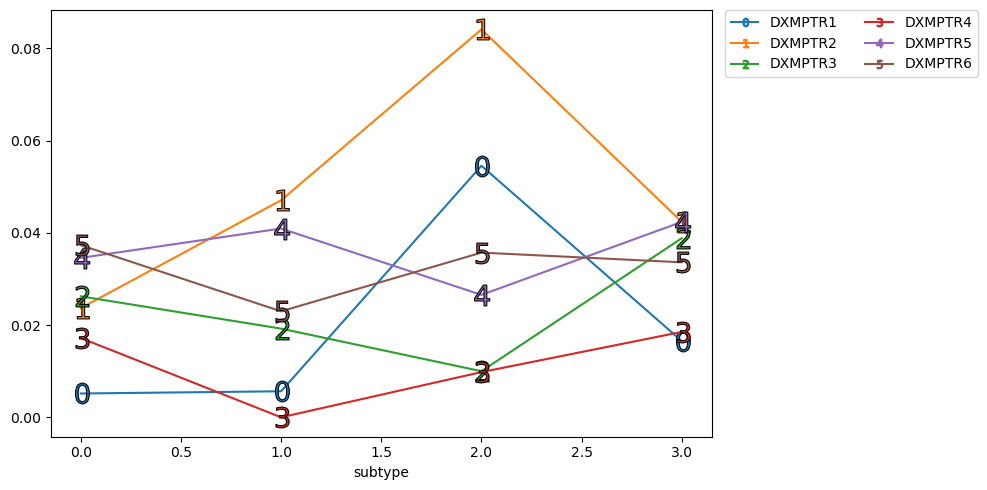

In [141]:
flds = ["DXMPTR1","DXMPTR2","DXMPTR3","DXMPTR4","DXMPTR5","DXMPTR6", "DXMDUE", "DXMOTHET", "DXDSEV", "DXDDUE",
        "DXAPP", "DXAPOSS", "DXODES", "DXDEP", "DXPARK", "DXPATYP"]

binary = ["DXMPTR1","DXMPTR2","DXMPTR3","DXMPTR4","DXMPTR5","DXMPTR6"]
test_name = "pdxconv"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(10,5))

markers = ['${}$'.format(_) for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncols=2)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [142]:
neurobat_df

,chi-2-pval,spearmanr
DXMPTR1,0.001436,-0.040412
DXMPTR2,0.057816,0.021390
DXMPTR3,0.714798,0.072010
DXMPTR4,0.686989,0.030605
DXMPTR5,0.911658,0.016569
DXMPTR6,0.864172,-0.024609
DXMDUE,0.081576,0.025820
DXMOTHET,0.164702,0.024708
DXDSEV,0.155802,-0.092685
DXDDUE,0.013553,-0.022214


In [ ]:
multipletests(neurobat_df["chi-2-pval"],0.05,"fdr_bh")

In [ ]:
fld = "DXMPTR1"
df_mh_fld = df_mh.dropna(subset=[fld])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
print(fld, "Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table

# ECOGPT Results

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGPT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
# flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8"]
# flds = ["LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8"]
# flds = ["MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1",
 "DIVATT2", "DIVATT3", "DIVATT4"]
binary = []
test_name = "ecogpt"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


In [ ]:
neurobat_df

In [ ]:
fld = "ORGAN4"
df_mh_fld = df_mh.dropna(subset=[fld])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
print(fld, "Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]

In [ ]:
chi2_table

In [ ]:
neurobat_df

# ADAS

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNI1_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)

In [ ]:
flds = ["COT1SCOR", "COT2SCOR", "COT3SCOR", "COP7COMP","CO8NURSE","CO8MAGAZ","CO8WIZRD","CO8WIZRR","CO8VAN","CO8VANR","CO8LEPRD","CO8LEPRR"]
binary = []
test_name = "adas"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(10,5))

markers = ['${}$'.format(_) for _ in range(len(binary))]
sns.lineplot(ratio_df, ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncols=2)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [ ]:
neurobat_df

# Comorbidity Analysis

## APOE4 genotype across subtypes

In [104]:
df_apoe4 = df_adnimerge[["PTID", "APOE4"]].dropna().sort_values("PTID").drop_duplicates("PTID", keep="first")
df_mh = pd.merge(final_df, df_apoe4, on=["PTID"], how="inner", suffixes=[None, "_y"])

In [105]:
chi2_table = df_mh.groupby(["subtype", "APOE4"]).size().unstack(level=1)
chi2_contingency(chi2_table.values)


(9.014375636214629,
 0.17277120801849452,
 6,
 array([[436.6430732 , 303.21052632,  83.14640048],
        [213.81185723, 148.47368421,  40.71445856],
        [141.12643678,  98.        ,  26.87356322],
        [ 85.41863279,  59.31578947,  16.26557774]]))

# Medical History

In [106]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "MEDHIST_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [107]:
# fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH8MUSCL", "MH9ENDO", "MH10GAST", "MH11HEMA", "MH12RENA", "MH13ALLE", 
#                "MH14ALCH", "MH15DRUG", "MH16SMOK", "MH17MALI", "MH18SURG"]
fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH9ENDO", "MH11HEMA", "MH12RENA", 
               "MH14ALCH", "MH16SMOK", "MH17MALI"]

ft = "MH19OTHR"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
print(chi2_table, "\n\n")
print(chi2_contingency(chi2_table.values))


MH19OTHR    0    1
subtype           
0.0       667  160
1.0       325   79
2.0       197   69
3.0       133   28 


(6.681702707162776, 0.08276554529010742, 3, array([[659.4053076 , 167.5946924 ],
       [322.1278649 ,  81.8721351 ],
       [212.09408926,  53.90591074],
       [128.37273824,  32.62726176]]))


In [111]:
fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH8MUSCL", "MH9ENDO", "MH10GAST", "MH11HEMA", "MH12RENA", "MH13ALLE", 
               "MH14ALCH", "MH15DRUG", "MH16SMOK", "MH17MALI", "MH18SURG"]
# fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH9ENDO", "MH11HEMA", "MH12RENA", 
#                "MH14ALCH", "MH16SMOK", "MH17MALI"]
mh_dict = {}
for ft in fields_test:
    
    chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
    p_val = chi2_contingency(chi2_table.values)[1]
    st_max = (chi2_table[1]/chi2_table[0]).argmax()
    st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val, st_max, st_min)
    
    

In [112]:
fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole32_mixture_GMM/figures_4/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals", "st_max", "st_min"]
mh_df.sort_values("p-vals", inplace=True)

# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [113]:
mh_df

,p-vals,st_max,st_min
MH7DERM,0.000730,2,0
MH16SMOK,0.001432,3,0
MH17MALI,0.006816,3,0
MH9ENDO,0.012454,1,3
MH3HEAD,0.040125,2,0
MH12RENA,0.043817,3,0
MH4CARD,0.071238,2,0
MH6HEPAT,0.082405,2,0
MH10GAST,0.120697,0,3
MHPSYCH,0.145835,0,2


In [ ]:
p_vec1 = mh_df["p-vals"].sort_values()
p_vec2 = np.arange(1, p_vec1.shape[0]+1)

In [114]:
from statsmodels.stats.multitest import fdrcorrection

In [115]:
multipletests(mh_df["p-vals"], method="fdr_bh", alpha=0.1)[1]

array([0.01217604, 0.01217604, 0.03862349, 0.05292903, 0.12414744,
       0.12414744, 0.17300733, 0.17511128, 0.22798404, 0.24792007,
       0.30910663, 0.52684425, 0.75750247, 0.75750247, 0.80757508,
       0.88996468, 0.90322421])

In [116]:
mh_df["adj-p"] = multipletests(mh_df["p-vals"], method="fdr_bh", alpha=0.1)[1]

In [117]:
mh_df

,p-vals,st_max,st_min,adj-p
MH7DERM,0.000730,2,0,0.012176
MH16SMOK,0.001432,3,0,0.012176
MH17MALI,0.006816,3,0,0.038623
MH9ENDO,0.012454,1,3,0.052929
MH3HEAD,0.040125,2,0,0.124147
MH12RENA,0.043817,3,0,0.124147
MH4CARD,0.071238,2,0,0.173007
MH6HEPAT,0.082405,2,0,0.175111
MH10GAST,0.120697,0,3,0.227984
MHPSYCH,0.145835,0,2,0.247920


In [ ]:
ft = "MH17MALI"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
chi2_table["odds"] = chi2_table[1]/chi2_table[0]
chi2_table

In [ ]:
chi2_contingency(chi2_table)

In [ ]:
df_mh

In [ ]:
np.arange(1,10)

In [ ]:
multipletests(mh_df["p-vals"], 0.05, "fdr_bh")

# Subject Characteristics

## Parents history - not very useful (FAMHXPAR)

## Sibling History and parent history shows no effects

## Patient demographics

In [ ]:
final_df

## marriage and gender

In [94]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "PTDEMOG_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999],np.nan, inplace=True)

# df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
# df_mh.replace([-4,-1,9999], np.nan, inplace=True)

In [ ]:
# PTMARRY, PTNOTRT
fields_test = ["PTGENDER", "PTHAND", "PTEDUCAT", "PTWORKHS",
               "PTNOTRT", "PTTLANG", "PTETHCAT", "PTRACCAT", "PTMARRY", "PTHOME"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[2]/chi2_table[1]).argmax()
#     st_min = (chi2_table[2]/chi2_table[1]).argmin()
    mh_dict[ft] = p_val
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
mh_df.sort_values("p-vals", inplace=True)
# _ = "PTNOTRT"
# df_mh_fld = df_mh.dropna(subset=[_])
# df_mh_fld.drop_duplicates("RID", keep="first",inplace=True)
# chi2_table = df_mh_fld.groupby(["subtype", _]).size().unstack(level=1).fillna(0)
# p_val = chi2_contingency(chi2_table.values)[1]
# chi2_table, p_val

In [ ]:
mh_df["adj-pval"] = multipletests(mh_df["p-vals"], 0.1, "fdr_bh")[1]
mh_df

In [98]:
ft = "PTNOTRT"
df_mh_fld = df_mh.dropna(subset=ft)
chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
print(chi2_table, "\n\n")
chi2_contingency(chi2_table[[0,1]])
# print(chi2_table,"\n\n")
# print(chi2_table.T.div(chi2_table.sum(axis=0), axis=0))

PTNOTRT    0.0    1.0   2.0
subtype                    
0.0      149.0  520.0  10.0
1.0       42.0  271.0   0.0
2.0       37.0  179.0   4.0
3.0       35.0  195.0   4.0 




(13.627008674083283,
 0.003459435298249027,
 3,
 array([[123.21218487, 545.78781513],
        [ 57.64635854, 255.35364146],
        [ 39.78151261, 176.21848739],
        [ 42.35994398, 187.64005602]]))

In [68]:
df_mh_fld

,subtype,stage,DX,PTID,EXAMDATE,VISCODE,RID,PHASE,PTID_y,VISCODE_y,...,PTBIRPR,PTBIRGR,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,3.0,2.0,Controls,002_S_0295,2006-05-09,bl,295,ADNI1,002_S_0295,sc,...,NaN,NaN,706,101,2006-04-04,NaN,NaN,NaN,NaN,2006-04-04 00:00:00.0
2,1.0,2.0,Controls,002_S_0559,2006-06-20,bl,559,ADNI1,002_S_0559,sc,...,NaN,NaN,1028,101,2006-05-11,NaN,NaN,NaN,NaN,2006-05-11 00:00:00.0
3,0.0,5.0,AD,002_S_0955,2006-10-25,bl,955,ADNI1,002_S_0955,sc,...,NaN,NaN,1850,101,2006-10-02,NaN,NaN,NaN,NaN,2006-10-02 00:00:00.0
4,0.0,3.0,AD,002_S_1018,2006-12-14,bl,1018,ADNI1,002_S_1018,sc,...,NaN,NaN,2194,101,2006-11-21,NaN,NaN,NaN,NaN,2006-11-21 00:00:00.0
5,3.0,3.0,Controls,002_S_1261,2007-02-27,bl,1261,ADNI1,002_S_1261,sc,...,NaN,NaN,2520,101,2007-01-30,NaN,NaN,NaN,NaN,2007-01-30 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,3.0,1.0,MCI,941_S_4036,2011-07-06,bl,4036,ADNI2,941_S_4036,v01,...,NaN,NaN,110,58,2011-05-05,NaN,NaN,NaN,NaN,2013-05-30 10:05:05.0
1445,0.0,0.0,MCI,941_S_4187,2011-08-25,bl,4187,ADNI2,941_S_4187,v01,...,NaN,NaN,458,58,2011-08-15,NaN,NaN,NaN,NaN,2013-05-30 10:05:05.0
1446,0.0,3.0,MCI,941_S_4377,2012-02-14,bl,4377,ADNI2,941_S_4377,v01,...,NaN,NaN,974,58,2011-11-16,2011-11-16,NaN,NaN,NaN,2013-05-30 10:05:05.0
1447,0.0,0.0,MCI,941_S_4420,2012-04-03,bl,4420,ADNI2,941_S_4420,v01,...,NaN,NaN,1664,58,2012-03-13,2012-04-13,NaN,NaN,NaN,2013-05-30 10:05:05.0


In [ ]:
ft = "PTMARRY"
df_mh_fld = df_mh.dropna(subset=ft)
chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
# print(chi2_table,"\n\n")
chi2_table["no"] = chi2_table[[2,3,4,5]].sum(axis=1)
chi2_marry = chi2_table[[1.0, "no"]]
chi2_marry.div(chi2_marry.sum(axis=1), axis=0)

# PTCOGBEG, PTADBEG - beginning of cog decline and AD

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "PTDEMOG_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999],np.nan, inplace=True)

In [ ]:
df_mh["PTADDX"].fillna(df_mh["PTADBEG"], inplace=True)
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

In [ ]:
fld = "PTCOGBEG"
ptid_list = cnad_ptid + mci_ptid
df_mh_subset = df_mh[df_mh["PTID"].isin(ptid_list)]
df_mh_subset.dropna(subset=fld, inplace=True)
df_mh_subset.sort_values(["PTID", "VISDATE"], inplace=True)
df_mh_subset.drop_duplicates("PTID",keep="first",inplace=True)
cogbeg_dict = dict(zip(df_mh_subset["PTID"], df_mh_subset[fld]))

fld = "PTADDX"
df_mh_subset = df_mh[df_mh["PTID"].isin(ptid_list)]
df_mh_subset.dropna(subset=fld, inplace=True)
df_mh_subset.sort_values(["PTID", "VISDATE"], inplace=True)
df_mh_subset.drop_duplicates("PTID",keep="first",inplace=True)
adbeg_dict = dict(zip(df_mh_subset["PTID"], df_mh_subset[fld]))

In [ ]:

df_temp = final_df.merge(df_long, left_on=["PTID", "EXAMDATE"], right_on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_y"])
df_temp = df_temp[["PTID", "subtype", "stage", "APOE4", "PTGENDER", "PTEDUCAT"]]
df_temp["PTGENDER"] = df_temp["PTGENDER"].map({"Male":1, "Female":0})
# df_long.sort_valuesdrop_duplicates( ["APOE4"]

In [ ]:
cogbeg_df = pd.DataFrame.from_dict(cogbeg_dict, orient="index", columns=["cogbeg"])
adbeg_df = pd.DataFrame.from_dict(adbeg_dict, orient="index", columns=["adbeg"])
df_beg = cogbeg_df.merge(adbeg_df, left_index=True, right_index=True, how="outer")
df_beg = df_beg.merge(df_mh[["PTID", "PTDOBYY"]].dropna(subset="PTDOBYY").drop_duplicates("PTID"), 
             left_index=True, right_on="PTID", how="inner")

# df_beg = df_beg.merge(final_df, left_on="PTID", right_on="PTID", how="inner")
df_beg = df_beg.merge(df_temp, left_on="PTID", right_on="PTID", how="inner")
df_beg["subtype"] = df_beg["subtype"].astype(int)
df_beg["subtype"] += 1
df_beg["AGEADBEG"] = df_beg["adbeg"] - df_beg["PTDOBYY"]
df_beg["AGECOGBEG"] = df_beg["cogbeg"] - df_beg["PTDOBYY"]
df_beg_ad = df_beg.dropna(subset="AGEADBEG")
df_beg_cog = df_beg.dropna(subset="AGECOGBEG")
df_beg_ad.rename(columns={"AGEADBEG":"age"}, inplace=True)
df_beg_ad["onset"] = "AD onset"
df_beg_cog.rename(columns={"AGECOGBEG":"age"}, inplace=True)
df_beg_cog["onset"] = "cognitive symptoms"




In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxenplot(data=pd.concat([df_beg_cog, df_beg_ad], axis=0), 
              x="subtype", y="age", hue="onset", orient="v",
             palette="YlOrRd", linewidth=1.5, color="g")
ax.set_xlabel("Subtype", fontsize=15)
ax.set_ylabel("Age of onset", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(os.path.join("/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4",
                         "age-onset.png"), dpi=300)

## Age of cognitive symptom onset adjusted for gender, education, and APOE4 

In [ ]:
df_regress = df_beg_cog.dropna(subset=["age", "APOE4", "PTGENDER", "PTEDUCAT"])
model = sm.OLS(df_regress[["age"]], sm.add_constant(df_regress[["APOE4", "PTGENDER", "PTEDUCAT"]]))
result = model.fit()
df_regress["age_adj"] = result.resid
sns.boxenplot(data=df_regress, x="subtype", y="age_adj")
kruskal(*[group["age_adj"].values for name, group in df_regress.groupby("subtype")])

## Age of AD diagnosis adjusted for gender, education, and APOE4 

In [ ]:
df_regress = df_beg_ad.dropna(subset=["age", "APOE4", "PTGENDER", "PTEDUCAT"])
model = sm.OLS(df_regress[["age"]], sm.add_constant(df_regress[["APOE4", "PTGENDER", "PTEDUCAT"]]))
result = model.fit()
df_regress["age_adj"] = result.resid
sns.boxenplot(data=df_regress, x="subtype", y="age_adj")
kruskal(*[group["age_adj"].values for name, group in df_regress.groupby("subtype")])

In [ ]:
_="AGECOGBEG"
pairs = [(0,1),(1,2),(2,3),(0,2),(0,3),(1,3)]
fig, ax = plt.subplots(1,1, figsize=(6,3), sharey=True)
df_mh_cog = df_beg.dropna(subset=[_])
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax)
annotator = Annotator(ax, pairs, data=df_mh_cog, x="subtype", y=_)
annotator._pvalue_format.pvalue_thresholds =  [[1e-4, '*'], [1e-6, '**'], [1e-8, '***'], [1e-10, '****'], [1, 'ns']]
annotator.configure(test='Mann-Whitney', text_format='star', 
                    loc='inside',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

In [ ]:
_="AGECOGBEG"
fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=True)
df_mh_cog = df_beg.dropna(subset=[_])
# df_mh_cog.drop_duplicates("PTID",keep="first",inplace=True)
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax[0])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

_="AGEADBEG"
df_mh_ad = df_beg.dropna(subset=[_])
# df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax[1])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

In [ ]:
df_mh_ad.groupby("subtype")["AGEADBEG"].median() - df_mh_cog.groupby("subtype")["AGECOGBEG"].median()


In [ ]:
df_mh["AGEADBEG"] = df_mh["PTADDX"] - df_mh["PTDOBYY"]
df_mh["AGECOGBEG"] = df_mh["PTCOGBEG"] - df_mh["PTDOBYY"]

In [ ]:
_="AGECOGBEG"
fig, ax = plt.subplots(1,2, sharey=True)
df_mh_cog = df_mh.dropna(subset=[_])
df_mh_cog.drop_duplicates("PTID",keep="first",inplace=True)
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax[0])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

_="AGEADBEG"
df_mh_ad = df_mh.dropna(subset=[_])
df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax[1])
# df_mh_fld_ad["onset"] = "AD"
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

In [ ]:
_="AGEADBEG"
fig, ax = plt.subplots()
df_mh_ad = df_mh.dropna(subset=[_])
df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax)
# df_mh_fld_ad["onset"] = "AD"
ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

In [ ]:
df_onset = pd.concat([df_mh_cog, df_mh_ad], axis=0)
sns.boxenplot(data=df_onset, x="subtype", y=_, hue="onset")

In [ ]:
df_onset

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(6,3))
df_mh_cog_beg = df_mh.dropna(subset=["AGECOGBEG"])
# sns.boxenplot(data=df_mh_fld, x="subtype", y=_, ax = ax[0])
# kruskal(*[group[_].values for name, group in df_mh_fld.groupby("subtype")])
df_mh_ad_beg = df_mh.dropna(subset=["AGEADBEG"])



In [ ]:
df_assess

In [ ]:
df_mh_ad_beg

In [ ]:
chi2_table.div(chi2_table.sum(axis=1), axis=0)

In [ ]:
chi2_table.sum(axis=1)

# Rurality - doesn't help

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "RURALITY_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999], np.nan, inplace=True)

In [ ]:
_ = "RUCC"
df_mh_fld = df_mh.dropna(subset=[_])
chi2_table = df_mh_fld.groupby(["subtype", _]).size().unstack(level=1).fillna(0)
p_val = chi2_contingency(chi2_table.values)[1]
chi2_table, p_val

# NeuroExam

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "NEUROEXM_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-1,-4], np.nan, inplace=True)


In [ ]:
fields_test = ["NXVISUAL", "NXAUDITO", "NXTREMOR", "NXCONSCI", "NXNERVE", "NXMOTOR",
               "NXFINGER", "NXHEEL", "NXSENSOR", "NXTENDON", "NXPLANTA", "NXGAIT", "NXOTHER", "NXABNORM"]

mh_dict = {}
for ft in fields_test:
    
    chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
    st_max = (chi2_table[1]/chi2_table[2]).argmax()
    st_min = (chi2_table[1]/chi2_table[2]).argmin()
    mh_dict[ft] = (p_val, st_max, st_min)

In [ ]:
df_mh.groupby(["subtype", "NXOTHER"]).size().unstack(level=1)

In [ ]:
multipletests(pd.DataFrame.from_dict(mh_dict, orient="index")[0], 0.05, "fdr_bh")

# VITALS

In [ ]:
def process_df_subtypes(df, fld, ptid="PTID", examdate="EXAMDATE"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values([ptid, examdate], inplace=True)
    df_fld.drop_duplicates(ptid, keep="first", inplace=True)
    return df_fld

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "VITALS_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, left_on=["PTID", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
fld = "VSTEMP"
df_vitals_xx = process_df_subtypes(df_mh, fld)
sns.boxenplot(data=df_vitals_xx, x="subtype", y=fld)

# Modified Hachinski

In [128]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MODHACH_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1], np.nan, inplace=True)


In [ ]:
fields_test = ["HMONSET", "HMSTEPWS", "HMSOMATC", "HMEMOTIO",
          "HMHYPERT", "HMSTROKE", "HMNEURSG", "HMNEURSM", "HMSCORE"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[1]/chi2_table[0]).argmax()
#     st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val,)

fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [ ]:
multipletests(mh_df["p-vals"], 0.1, "fdr_bh")

In [136]:
ft = "HMSCORE"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
# fig, ax = plt.subplots()
# ax.plot(chi2_table[1]/chi2_table[0])
# ax.set_ylabel("Odds of hypertension history")
# ax.set_xlabel("Stage")
print(chi2_table, "\n\n")
chi2_contingency(chi2_table)

HMSCORE    0.0    1.0   2.0   3.0  4.0
subtype                               
0.0      391.0  351.0  33.0  13.0  2.0
1.0      147.0  166.0  12.0  12.0  2.0
2.0      117.0  133.0   4.0  12.0  0.0
3.0      139.0  108.0   9.0   6.0  1.0 




(21.159257598071072,
 0.048096446168972865,
 12,
 array([[378.32328106, 361.17008444,  27.63570567,  20.48854041,
           2.38238842],
        [162.3437877 , 154.98311218,  11.8588661 ,   8.79191797,
           1.02231604],
        [127.38480097, 121.60916767,   9.30518697,   6.8986731 ,
           0.80217129],
        [125.94813028, 120.23763571,   9.20024125,   6.82086852,
           0.79312425]]))

# NEUROEXM

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "NEUROEXM_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [ ]:
chi2_table = df_mh.groupby(["subtype", "NXABNORM"]).size().unstack(level=0).T

In [ ]:
chi2_table

In [ ]:
chi2_contingency(chi2_table.values)

# PHYSICAL

In [124]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "PHYSICAL_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1], np.nan, inplace=True)

In [ ]:
fields_test = ["PXHEADEY", "PXCHEST", "PXHEART", "PXABDOM",
               "PXEDEMA", "PXPERIPH", "PXSKIN", "PXMUSCUL", "PXBACK"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[1]/chi2_table[0]).argmax()
#     st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val,)

fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [ ]:
multipletests(mh_df["p-vals"], 0.05, "fdr_bh")

In [126]:
chi2_table = df_mh.groupby(["subtype", "PXSKIN"]).size().unstack(level=1).fillna(0)
chi2_table

PXSKIN,1.0,2.0
subtype,,
0.0,672,118
1.0,261,78
2.0,228,38
3.0,215,48


In [ ]:
chi2_table[2.0]/chi2_table[1.0]

In [127]:
chi2_contingency(chi2_table.values)

(12.733702590957677,
 0.005249351963533455,
 3,
 array([[655.63329312, 134.36670688],
        [281.34137515,  57.65862485],
        [220.7575392 ,  45.2424608 ],
        [218.26779252,  44.73220748]]))

# RECMHIST

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "RECMHIST_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [ ]:
chi2_table = df_mh.groupby(["subtype", "MHNUM"]).size().unstack(level=1).fillna(0)

In [ ]:
chi2_table

In [ ]:
chi2_contingency(chi2_table)

# Scrap Work

In [ ]:
def append_counts_bar(df, st_min=0, st_max=5):
    if df["stage"].min() > st_min:
        new_row = {"stage":0.0, "DX":"Controls", "value":0.0}
#         new_row = {"stage":0.0, "DX":"MCI", "value":0.0}
#         new_row = {"stage":0.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    if df["stage"].max() < st_max:
        new_row = {"stage":5.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    return df

In [ ]:
subtype_select = 2
final_df_grouped = final_df[final_df["subtype"] == subtype_select].groupby(["stage", "DX"]).size().reset_index()
final_df_pivot = final_df_grouped.pivot(columns="DX", values=0, index="stage").fillna(0)
final_df_pivot /= final_df_pivot.sum(axis=0)
counts_bar = final_df_pivot.melt(ignore_index=False, value_vars=["Controls","AD","MCI"]).reset_index()

In [ ]:
counts_bar = append_counts_bar(counts_bar)
counts_bar["stage"] = counts_bar["stage"].astype(int)

In [ ]:
fig, ax = plt.subplots(figsize=(4,2))
hue_order=["Controls", "MCI", "AD"]
palette = ["g", "orange","r"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="DX",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("stage", fontsize=15)
ax.set_ylabel("")
    
ax.get_legend().remove()

ax.tick_params(axis='both', which='major', labelsize=15)


# ax.set_ylim([0])
ax.set_title("Subtype {}".format(int(subtype_select+1)), fontsize=12)
sns.despine()
plt.tight_layout()
fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_3/"
fname = "stage_hist_subtype_{}.png".format(int(subtype_select+1))
fig.savefig(os.path.join(fig_path, fname), dpi=300, transparent=True)


In [ ]:
k=118
df_total = pd.concat([df_mci, df_cnad], axis=0)
SuStaIn_df = pd.merge(df_total, final_df, on=["PTID", "EXAMDATE"])
SuStaIn_df = SuStaIn_df[SuStaIn_df["DX_y"]=="MCI"]
MRI_cols = SuStaIn_df.columns.tolist()[:k]
SuStaIn_cols = MRI_cols + ["subtype", "stage"]
SuStaIn_df_rel = SuStaIn_df[SuStaIn_cols]
SuStaIn_df_rel["subtype"] += 1
# df_total

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# palette="autumn_r",
SuStaIn_embedded = TSNE(n_components=2, learning_rate='auto',
                       init='pca', perplexity=30, random_state=0).fit_transform(SuStaIn_df_rel[MRI_cols].values)
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                palette = "viridis", s = 100, ax = ax[0],edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["subtype"].astype(int))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                s = 100, ax = ax[1], palette="YlOrBr", edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["stage"].astype(int))
ax[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="subtype",
             title_fontproperties={'weight':'bold', 'size':18})
ax[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="stage",
             title_fontproperties={'weight':'bold', 'size':18})

for ha in ax[0].legend_.legendHandles:
    ha.set_edgecolor("k")

for ha in ax[1].legend_.legendHandles:
    ha.set_edgecolor("k")
    
# ax[1].legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0., frameon=False)
ax[0].axis("off")
ax[1].axis("off")
fig.tight_layout()
fig.savefig(os.path.join(fig_path, "t-SNE_MCI_full.png"), dpi=400)


# Progression curves

In [ ]:
# def prepare_longitudinal_data(first_visit_df):
#     # Read the MRI data across all subjects
#     path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm.csv"
#     df = pd.read_csv(path)
#     sid = df["Measure:volume"].apply(lambda x: x.split("-",1))
#     df_sid = pd.DataFrame(sid.tolist(), columns=["sid", "time"])
#     sid_time = df_sid["time"].apply(lambda x: x.split("_",1))
#     df_sid_time = pd.DataFrame(sid_time.tolist(), columns=["date", "time"])
#     df_concat = pd.concat([df_sid, df_sid_time], axis=1)[["sid", "date"]]
#     df_concat["date"] = pd.to_datetime(df_concat["date"])

#     # Read the ADNIMERGE file     
#     adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
#     df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]
#     df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])
#     merged_df = df_adnimerge.merge(df_concat, left_on=["PTID", "EXAMDATE"], right_on=["sid", "date"])
    
#     # longitudinal_records
#     longitudinal_records = df_adnimerge.sort_values(["PTID", "EXAMDATE"]).set_index("PTID").dropna(subset=["DX"])
#     d = {}
#     for i, row in first_visit_df.iterrows():
#         ptid = row["PTID"]
#         d[ptid] = longitudinal_records.loc[ptid, :]
#     return d, merged_df
    

In [ ]:
def prepare_longitudinal_data_newL(first_visit_df):
    path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
    df = pd.read_csv(path)
    df.dropna(subset=["DX"], inplace=True)
    df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"])
    
    # longitudinal_records
    meta_cols = ["DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4", "PTID"]
    longitudinal_records = df.sort_values(["PTID", "EXAMDATE"]).dropna(subset=["DX"])[meta_cols]
    
    d = {}
    for i, row in first_visit_df.iterrows():
        ptid = row["PTID"]
        d[ptid] = longitudinal_records[longitudinal_records["PTID"].isin([ptid])].reset_index(drop=True)
    return d, longitudinal_records

In [ ]:
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

In [ ]:
d, merged_df = prepare_longitudinal_data_newL(final_df)
mci_demographics = merged_df[merged_df["PTID"].isin(mci_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")
cn_demographics = merged_df[merged_df["PTID"].isin(cn_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
Su = 2.0
mci_subtype = mci_solved[mci_solved["subtype"]==Su]
fraction_mci = mci_subtype.shape[0]/mci_solved.shape[0]
cox_mci = mci_demographics[mci_demographics["PTID"].isin(mci_subtype["PTID"])]
dict_stage = dict(zip(mci_subtype["PTID"],mci_subtype["stage"]))

In [ ]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

for d_yr in delta_years:
    d_convert = {}
    d_timedelta = {}
    for i, row in mci_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=d_yr, months=0)
        if (d[ptid].shape[0] > 1):
            ptid_df = d[ptid].sort_values(["EXAMDATE"])
            ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                                & (ptid_df["EXAMDATE"] <= examdate_max)]
            ptid_forward_df = ptid_forward_df.reset_index(drop=True)
            srs = ptid_forward_df["DX"]
            first_dx = srs[0]
            assert first_dx == "MCI"
            bool_srs = srs == "Dementia"
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]            
            d_timedelta[ptid] = time_delta.days
            d_convert[ptid] = cnvrt
        else:
            d_timedelta[ptid] = np.NaN
            d_convert[ptid] = np.NaN

    mci_subtype["convert"] = mci_subtype["PTID"].map(d_convert)
    mci_subtype = mci_subtype[~mci_subtype["convert"].isna()]
    df_convert = mci_subtype[mci_subtype["convert"]==1]
    # dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(df_convert["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(mci_subtype["stage"])
    d_fractions = {}
    x = []; y = []; den_list = [];
    for i in range(n_stages+1):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d_fractions[i] = r
        x.append(i)
        y.append(r)
        den_list.append(den)
    ax.plot(x, y, label=str(d_yr) + " years", marker="o", color=d_colors[d_yr])
    if d_yr == 5:
        for i in range(n_stages+1):
            ax.annotate("n = "+str(den_list[i]), (x[i], y[i]), xytext=(20, 30),
              textcoords='offset points', ha='center', va='bottom', fontsize=15,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.set_xlabel("stage", fontsize=18)
    cox_mci["convert"] = cox_mci["PTID"].map(d_convert)
    cox_mci["time"] = cox_mci["PTID"].map(d_timedelta)
    cox_mci["subtype"] = Su
    cox_mci["stages_inferred"] = cox_mci["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}_mci.csv".format(Su,d_yr)
    cox_mci.to_csv(os.path.join(fig_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction_mci, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,1])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "mci_subtype_{}.png".format(Su)
fig.savefig(os.path.join(fig_path, fig_name), dpi=450)


In [ ]:
Counter(df_convert["stage"])

In [ ]:
Counter(mci_subtype["stage"])

## Controls progression

In [ ]:
d, merged_df = prepare_longitudinal_data_newL(final_df)
cn_demographics = merged_df[merged_df["PTID"].isin(cn_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
Su = 2.0
cn_solved = cnad_solved[cnad_solved["DX"]==0.0]
cn_subtype = cn_solved[cn_solved["subtype"]==Su]
fraction_cn = cn_subtype.shape[0]/cn_solved.shape[0]
cox_cn = cn_demographics[cn_demographics["PTID"].isin(cn_subtype["PTID"])]
dict_stage = dict(zip(cn_subtype["PTID"],cn_subtype["stage"]))

In [ ]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

for d_yr in delta_years:
    d_convert = {}
    d_timedelta = {}
    for i, row in cn_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=d_yr, months=0)
        if (d[ptid].shape[0] > 1):
            ptid_df = d[ptid].sort_values(["EXAMDATE"])
            ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                                & (ptid_df["EXAMDATE"] <= examdate_max)]
            ptid_forward_df = ptid_forward_df.reset_index(drop=True)
            srs = ptid_forward_df["DX"]
            first_dx = srs[0]
            assert first_dx == "CN"
            bool_srs = srs != first_dx
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]            
            d_timedelta[ptid] = time_delta.days
            d_convert[ptid] = cnvrt
        else:
            d_timedelta[ptid] = np.NaN
            d_convert[ptid] = np.NaN

    cn_subtype["convert"] = cn_subtype["PTID"].map(d_convert)
    cn_subtype = cn_subtype[~cn_subtype["convert"].isna()]
    df_convert = cn_subtype[cn_subtype["convert"]==1]
    # dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(df_convert["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(cn_subtype["stage"])
    d_fractions = {}
    x = []; y = []; den_list = [];
    for i in range(n_stages+1):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d_fractions[i] = r
        x.append(i)
        y.append(r)
        den_list.append(den)
    ax.plot(x, y, label=str(d_yr) + " years", marker="o", color=d_colors[d_yr])
    if d_yr == 5:
        for i in range(n_stages+1):
            ax.annotate("n = "+str(den_list[i]), (x[i], y[i]), xytext=(-20, 20),
              textcoords='offset points', ha='center', va='bottom',
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.set_xlabel("stage", fontsize=18)
    cox_cn["convert"] = cox_cn["PTID"].map(d_convert)
    cox_cn["time"] = cox_cn["PTID"].map(d_timedelta)
    cox_cn["subtype"] = Su
    cox_cn["stages_inferred"] = cox_cn["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}_cn.csv".format(Su,d_yr)
    cox_cn.to_csv(os.path.join(fig_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction_cn, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,0.3])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "cn_subtype_{}.png".format(Su)
fig.savefig(os.path.join(fig_path, fig_name), dpi=450)


In [ ]:
den_list

In [ ]:
Counter(df_convert["stage"])

In [ ]:
Counter(cn_subtype["stage"])

## Longitudinal data analysis

In [ ]:
# Functions for reading longitudinal data and subtyping/staging
def read_long(df_cnad, df_mci, k):
    long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
    df_long = pd.read_csv(long_path)
    df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])
    assert all(df_long.columns[:k] == df_cnad.columns[:k])
    cnad_ptid = df_cnad["PTID"].tolist()
    mci_ptid = df_mci["PTID"].tolist()
    df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
    df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]
    return df_long, df_long_cnad, df_long_mci

def subtype_stage(L_yes, L_no, pkl, n_stages, last_N=1000000, N_samples=1000):
    last_N = 1000000
    N_samples = 1000
    sustainData_mci_long = sEBMSustainData(L_yes, L_no, n_stages)
    samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
    samples_f = pkl["samples_f"][:,-last_N:]
    shape_seq = pkl["shape_seq"]
    temp_mean_f = np.mean(samples_f, axis=1)
    ix = np.argsort(temp_mean_f)[::-1]

    ml_subtype, \
    prob_ml_subtype, \
    ml_stage, \
    prob_ml_stage, \
    prob_subtype, \
    prob_stage, \
    prob_subtype_stage,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)
    return ml_subtype, prob_ml_subtype, ml_stage, prob_ml_stage, prob_subtype, prob_stage, prob_subtype_stage

# Read the long df (MCI and CNAD)
k = 118
df_long, df_long_cnad, df_long_mci = read_long(df_cnad, df_mci, k)

# Get the prob_mat for MCI
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

# Subtype and Stage the MCI subjects and subset them for the relevant columns
ml_subtype_mci, prob_ml_subtype_mci, ml_stage_mci, \
prob_ml_stage_mci, prob_subtype_mci, prob_stage_mci, prob_subtype_stage_mci = subtype_stage(L_yes_mci_long, L_no_mci_long, pkl, n_stages)
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci_subset = df_long_mci[mci_subset]

In [ ]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)

In [ ]:
df_long_cnad.shape

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
df_long = pd.read_csv(long_path)
df_long.dropna(subset=["DX"], inplace=True)
df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])

In [ ]:
k=118
all(df_long.columns[:k] == df_cnad.columns[:k])

In [ ]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [ ]:
d, merged_df = prepare_longitudinal_data_newL(final_df)

In [ ]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [ ]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [ ]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)

In [ ]:
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci

In [ ]:
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci[mci_subset]

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
df_long = pd.read_csv(long_path)
df_long.dropna(subset=["DX"], inplace=True)
df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])

In [ ]:
df_long.shape

In [ ]:
len(set(df_long["sid"]))

In [ ]:
# set(df_long["sid"])-set(final_df["PTID"])

In [ ]:
len(set(final_df["PTID"]))

In [ ]:
k=118
all(df_long.columns[:k] == df_cnad.columns[:k])

In [ ]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [ ]:
d, merged_df = prepare_longitudinal_data_newL(final_df)

In [ ]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [ ]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [ ]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)


In [ ]:
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci

In [ ]:
df_long_mci

In [ ]:
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci[mci_subset]

In [ ]:
df_mh = pd.merge(df_long_mci[mci_subset], df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner")
df_mh.replace(-1,np.nan, inplace=True)

In [ ]:
fld = "AVDEL30MIN"
df_mh.dropna(subset=[fld], inplace=True)

In [ ]:
df_mh.sort_values(["PTID", "EXAMDATE_x"], inplace=True)
df_mh.drop_duplicates("PTID", keep="first", inplace=True)

In [ ]:

chi2_table = df_mh.groupby(["stage", fld]).size().unstack(level=1).fillna(0)

In [ ]:
chi2_contingency(chi2_table)

In [ ]:
df_mh.shape, chi2_table

In [ ]:
st = 3
kendalltau(df_mh[df_mh["subtype"]==st]["stage"], df_mh[df_mh["subtype"]==st][fld])

In [ ]:
mci_long_subtype_stage = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_long_subtype_stage = pd.DataFrame(mci_long_subtype_stage, columns=["subtype", "stage"])
mci_long_subtype_stage[["sid", "date"]] = df_long_mci.reset_index(drop=True)[["sid", "date"]]
mci_long_subtype_stage["date"] = pd.to_datetime(mci_long_subtype_stage["date"])
df_followup = mci_long_subtype_stage
df_followup = df_followup.sort_values(["sid", "date"])

In [ ]:
def get_pairs(vec):
    trns = []
    l = vec.shape[0]
    for i in range(1,l):
        trns.append((vec[:i][-1], vec[i:][0]))
    return trns

sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["subtype"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

In [ ]:
count = np.zeros((4,4))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("subtype in last visit", fontsize=21)
ax.set_xlabel("subtype in next visit", fontsize=21)
ax.set_xticklabels([1,2,3,4], fontsize=21)
ax.set_yticklabels([1,2,3,4], fontsize=21)
fig_name = "longitudinal_subtype_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(fig_path, fig_name), dpi=300, transparent=True)

In [ ]:
count.trace() , count.sum()

In [ ]:
count.trace()/count.sum()

## Stage transition matrix

In [ ]:
sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["stage"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

In [ ]:
count = np.zeros((6,6))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("Stage in last visit", fontsize=21)
ax.set_xlabel("Stage in next visit", fontsize=21)
ax.set_xticklabels([0,1,2,3,4,5], fontsize=21)
ax.set_yticklabels([0,1,2,3,4,5], fontsize=21)
fig_name = "longitudinal_stage_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(fig_path, fig_name), dpi=300, transparent=True)

In [ ]:
x_ = np.array([0.35,0.27,0.15,0.23])
np.dot(x_,x_)

In [ ]:
mci_long_subtype_stage[["sid", "date"]]

In [ ]:
df_long_mci

In [ ]:
mci_demographics, mci_solved

In [ ]:
mci_solved["EXAMDATE"]

In [ ]:
mci_demo_full = pd.merge(mci_demographics, mci_solved, on=["PTID", "EXAMDATE"])

In [ ]:
mci_solved

In [ ]:
final_df

In [ ]:
mci_demo_full.head()

In [ ]:
mci_demo_full

In [ ]:
mci_demo_full.groupby(["subtype", "APOE4"]).size()

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='stage', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_demographics = merged_df[merged_df["DX"].isin(["CN", "MCI", "Dementia"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
len(set(all_demographics["PTID"]))

In [ ]:
all_demographics

In [ ]:
all_data = pd.merge(all_demographics, final_df, on=["PTID", "EXAMDATE"])

In [ ]:
all_data.pivot_table(index='subtype', columns='DX_x', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data[all_data["DX_x"].isin(["CN", "Dementia"])].pivot_table(index='subtype', columns='PTGENDER', 
                        aggfunc=len, fill_value=0)["PTID"]

# Scrap Analysis

In [ ]:
adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/df12_longitudinal_ebm.csv"
df_long = pd.read_csv(long_path)

In [ ]:
len(set(df_adnimerge["PTID"].tolist()))

In [ ]:
len(set(df_long["sid"].tolist()))

In [ ]:
327 + 551

In [ ]:
cols = df_mci.columns[:k].tolist()

In [ ]:
pandas